In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy as sp
import scipy.stats
import seaborn as sns
from matplotlib import cm
import networkx as nx
import pandas as pd
import itertools
from matplotlib import animation
import os
# Using matplotlib notebook allows you to interact with the resulting 3-D figure
%matplotlib inline

In [2]:
import sys
sys.path.append(r'src')
import curvgrad as cg
import trngln
from importlib import reload
reload(cg)
reload(trngln)

<module 'trngln' from 'src/trngln.py'>

In [3]:
# two methods for animation - see:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
# 1 - directly inline via %matplotlib notebook - advantage: real-time, disadvantage: no manual control
# 2 - encode as video, embedded into notebook (base64) and display via notebook player or JS widget
#     downside - not real time, need to generate complete video before it can be displayed
# 2a - HTML(anim.to_html5_video())  [notebook player, bare bones] [uses html5 <video> tag]
# 2b - HTML(anim.to_jshtml())  [JS widget, extra controls]
# these latter can be made default representation via next line, which can also be 'html5'
mp.rcParams['animation.html'] = 'jshtml'
# 3 - save as an animated GIF and display using 
# rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')
# ![RotatingImage](rotation.gif "Quadratic Form")
# see also https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531

In [4]:
refc = pd.read_csv('Data/mark_us_curv.csv', index_col = 0)
refc.columns = refc.columns.astype('float')

### Create the 3D Mesh and its Triangulation

First create a 2D x-y mesh

In [5]:
cellcoords = np.array(list(itertools.product(refc.index, refc.columns)), dtype='float')
# we assume that ncols = nrows in the input dataframe
gridsize = len(refc.columns)
x = np.reshape(cellcoords[:,0], (gridsize, gridsize))
y = np.reshape(cellcoords[:,1], (gridsize, gridsize))
z = np.zeros((gridsize, gridsize))
curvatures = np.reshape([refc.loc[x, y] for x, y in itertools.product(refc.index, refc.columns)], 
                        (gridsize, gridsize))

In [6]:
# x and y are the corresponding indices of a 2D mesh
# x, y = np.mgrid[-edge:edge:.05, -edge:edge:.05]
# create the structure needed for evaluating pdfs
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
gridsize = x.shape[0]

Now create the triangulation of the 3D mesh

In [7]:
Tr = trngln.trngln(gridsize)
triangles = Tr.triangles()

In [8]:
G = Tr.regularization_graph()
L = nx.laplacian_matrix(G)
L3 = L @ L @ L

In [9]:
xf = x.flatten()
yf = y.flatten()
zf = z.flatten()

In [10]:
def get_triangle_vertices(triangles, xf, yf, zf):
    # this is the actual mesh we will plot
    return np.array([np.array([[xf[T[0]], yf[T[0]], zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], zf[T[2]]]]) for T in triangles])
def get_vertices(xf, yf, zf):
    # list of coordinates of each triangle
    return np.array(list(zip(xf, yf, zf)))

triangle_vertices = get_triangle_vertices(triangles, xf, yf, zf)
vertices = get_vertices(xf, yf, zf)

### Visualization of Meshes

In [11]:
def viz(triangle_vertices, facecolors):

    # plot the triangle mesh
    coll = Poly3DCollection(triangle_vertices, facecolors=facecolors, linewidth=0.1,
                        edgecolors='gray')

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.add_collection(coll)
    ax.view_init(elev=0, azim=135)

    plt.axis('off')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.elev = 50
    return ax

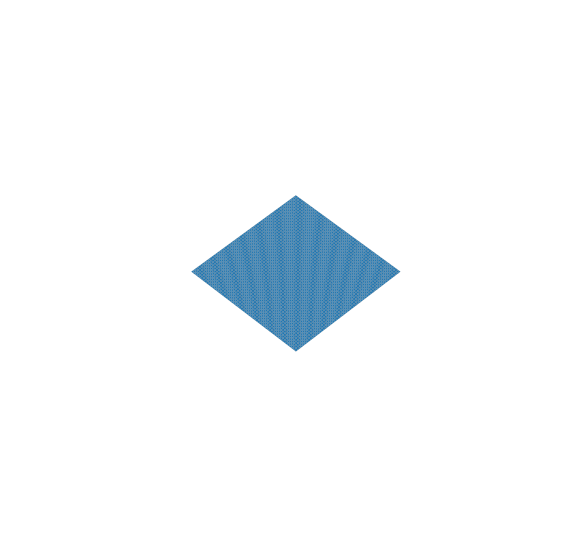

In [12]:
viz(triangle_vertices, None)

#### Coloring a mesh according to curvature

__Basic idea of how to color the mesh:__

1. For each vertex, get all adjacent triangles
    * For each triangle, compute its angle at that vertex
    * Then sum all angles to compute the local curvature at that vertex
3. For each triangle, compute average curvature of its vertices
4. Color the triangle according to the average curvature of its vertices

__Geometry:__

Given a triangle with vertices $p_0, p_1, p_2$.   Assume you want to compute the angle at vertex $p_0$.

Let $v = p_1 - p_0,$ $u = p_2 - p_0$.  Then $\theta = \cos^{-1}\frac{u^T v}{\Vert u\Vert \Vert v\Vert}$

#### Compute the angle of vertex $b$ in triangle $T$

In [13]:
def angle_of_b_in_t(b, T, vertices):
    '''
    for a vertex b which is an index into vertices
    and a triangle T (which is a triple)
    return the angle formed by the two triangles sides at vertex b
    '''
    others = [t for t in T if t != b]
    u = np.array(vertices[others[0]] - vertices[b])
    v = np.array(vertices[others[1]] - vertices[b])
    return np.arccos((u.T @ v) / (np.linalg.norm(u) * np.linalg.norm(v)))

#### Compute the curvature at vertex $b$.

The curvature at a vertex $= 2 \pi - \sum$ angles around vertex

In [14]:
def vertex_curvature(b, t_of_v, vertices):
    # find the angles of the edges incident at each vertex b
    # t_of_v[b] is the set of triangles incident to vertex b
    angles = [angle_of_b_in_t(b, t, vertices) for t in t_of_v[b]]
    if len(angles) == 6:
        # this is an interior vertex
        return 2 * np.pi - np.sum(angles)
    #elif len(angles) == 3:
        #return np.pi - np.sum(angles)
    #elif len(angles) == 2:
        #return (np.pi / 2) - np.sum(angles)
    #elif len(angles) == 1:
        #return (np.pi / 2) - np.sum(angles)
    else:
        # this vertex does not have the standard number of neighbors (6)
        # which happens at the edge of the mesh
        # so just ignore it - will be filtered out of the visualization
        return np.nan 
    
def get_curvature(vertices, t_of_v):
    return np.array([vertex_curvature(v, t_of_v, vertices) for v in range(len(vertices))])

Apply the above functions to compute the curvature at each vertex

In [15]:
t_of_v = Tr.triangles_of_vertex()

#### Visualize

Given the above histogram, the small number of points with very large curvature will distort the scale and hide the variation of curvature around zero.   So we artificially clamp all values above a threshold, and rescale the values close to zero so they can be seen.

In [16]:
def rmap(x, oldmin, newmin, oldmax, newmax, newzero):
    '''
    linear rescaling for visualization purposes
    rescale from range [oldmin, 0] to [newmin, newzero]
    and from [0, oldmax] to [newzero, newmax]
    '''
    if x > 0:
        return (x/oldmax)*(newmax-newzero)+newzero
    elif x < 0:
        return (x/oldmin)*(newmin-newzero)+newzero
    else:
        return newzero
        
def viz_curvature(vertices, t_of_v, triangles, cmap = cm.seismic, maxscale = 0.1):
    
    # compute the curvature at each vertex
    cv = get_curvature(vertices, t_of_v)
    
    # Compute the average curvature for each triangle
    pcv = np.array([np.nanmean(cv[triangles[t]]) for t in range(len(triangles))])

    # for visualization, concentrate on intermediate curvature values
    # only visualize cuvatures in range [-maxscale, maxscale]
    # all other values are set to maxscale or -maxscale

    # first, set all values above maxscale to maxscale 
    pcv[pcv > maxscale] = maxscale
    pcv[pcv < -maxscale] = -maxscale
    
    # remap values and compute colors of each triangle
    facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])

    viz(triangle_vertices, facecolors);

## Warping a surface to match a curvature

### Build a test case

Get a curvature value for each point

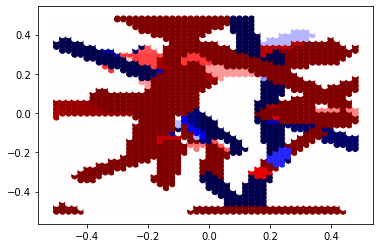

In [17]:
cmap = cm.seismic
maxscale = 0.1
plt.scatter(xf, yf, color = [cmap(rmap(p, -maxscale, 0, maxscale, 1, 0.5)) for p in curvatures.flatten()])

### Loss Function

Let the intended curvature at grid point $i$ be $\kappa(i)$ and the current curvature be $c(i)$.   Then to match the observed curvature, the objective function is:

$$ \mathcal{L} = \sum_i (\kappa(i) - c(i))^2. $$

Each point has three coordinates, ie, $a = (x_a, y_a, z_a)$.  In order to use gradient descent to minimize this loss function we need to compute
$$ \frac{\partial \mathcal{L}}{\partial z} $$
where $z = [z_i]^T$.  Written out, the above is $[\frac{\partial \mathcal{L}}{\partial z_i}]^T$.

### Gradient

The gradient we seek is:
    $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) $$
    
(which could be 
    $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) + \lambda \frac{\partial f}{\partial z}$$
   if we want to smooth the curvature using one of the above penalizations $f(z)$.)

### Functions for computing gradient

In [18]:
# test case
kappa = curvatures.flatten()

In [19]:
zf = 0.001 * curvatures.flatten()
# zf = 0.001 * np.random.random(576)
vertices = get_vertices(xf, yf, zf)
c = get_curvature(vertices, t_of_v)

In [20]:
grad = cg.L_grad(len(vertices), kappa, c, t_of_v, vertices)

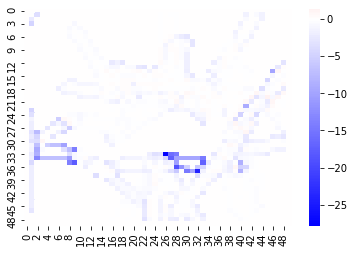

In [21]:
sns.heatmap(np.reshape(grad, (gridsize, gridsize)), cmap = cm.bwr, center = 0)

(2500,)

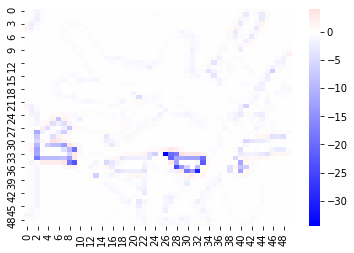

In [22]:
grad = cg.L_grad_penalized(1000, L @ zf, len(vertices), kappa, c, t_of_v, vertices)
sns.heatmap(np.reshape(grad, (gridsize, gridsize)), cmap = cm.bwr, center = 0)
np.ravel(grad).shape

In [23]:
def objfn(kappa, c):
    diff = kappa-c
    diff = diff * diff
    return np.nansum(diff)

def complete_objfn(kappa, c, smooth_pen, penval):
    ob = objfn(kappa, c)
    return ob + smooth_pen * penval

In [24]:
objfn(kappa, c)

145.4669441549581

In [25]:
def single_step(smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = cg.L_grad_penalized(smooth_pen, L @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad, penalty = L_grad_penalized_with_convexity(100, L, zf, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad = L_grad_penalized_biased(10, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    new_zf = zf - rate * grad
    new_vertices = get_vertices(xf, yf, new_zf)
    new_cv = get_curvature(new_vertices, t_of_v)
    return new_zf, new_cv, new_vertices, grad

def single_step_with_momentum(prev_step, momentum, smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = cg.L_grad_penalized(smooth_pen, L @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    prev_step = ((1-momentum) * grad) + (momentum * prev_step)
    new_zf = zf - rate * prev_step
    new_vertices = get_vertices(xf, yf, new_zf)
    new_cv = get_curvature(new_vertices, t_of_v)
    return new_zf, new_cv, new_vertices, prev_step

In [26]:
def generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, t_of_v, niter = 1000, verbose = False):
    # initialize
    zf = kappa.copy()
    zf[np.isnan(zf)] = 0
    zf[zf<0] = 0
    vertices = get_vertices(xf, yf, zf)
    cv = get_curvature(vertices, t_of_v)
    of = objfn(kappa, cv)
    cof = complete_objfn(kappa, cv, smooth_pen, zf.T @ L @ zf)
    old_of = of
    old_cof = cof
    errvals = []
    c_errvals = []
    #
    # initial rate setting
    if verbose:
        print('starting rate setting: rate: {} obj fn: {} complete obj fn: {}'.format(rate, of, cof))   
    new_zf, new_cv, new_vertices, prev_step = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
    while (complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L @ new_zf) > old_cof):
        rate = rate / 1.1
        new_zf, new_cv, new_vertices, prev_step = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        if verbose:
            print('setup: -- lowering rate to {}'.format(rate))
    old_cof = complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L @ new_zf)
    old_of = objfn(kappa, new_cv)
    zf = new_zf
    cv = new_cv
    vertices = new_vertices
    if verbose:
        print('finished rate setting: rate: {} obj fn: {} complete obj fn: {}'.format(rate, old_of, old_cof))
    #
    # main loop
    for i in range(niter):
        # new_zf, new_cv, new_vertices, prev_step = single_step(
        #    smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        new_zf, new_cv, new_vertices, prev_step = single_step_with_momentum(prev_step, momentum,
            smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        of = objfn(kappa, new_cv)
        cof = complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L @ new_zf)
        # print('step: {} rate: {} obj fn: {} complete obj fn:{}'.format(i, rate, of, cof))
        if (cof > old_cof):
            rate = rate / 1.1
            if verbose:
                print('step: {} -- lowering rate to {}'.format(i, rate))
        elif (cof == old_cof):
            # rate has gone so low that no progress at all is being made
            rate = rate * 1.1
            if verbose:
                print('step: {} -- raising rate to {}'.format(i, rate))
        else:
            errvals.append(of)
            c_errvals.append(cof)
            old_of = of
            old_cof = cof
            zf = new_zf
            cv = new_cv
            vertices = new_vertices
            if (0 == i % 100):
                if verbose:
                    print('step: {}, obj fn: {}'.format(i, of))
                #fig, axs = plt.subplots(1, 3, figsize=(15,5))
                #sns.heatmap(np.reshape(new_zf, (gridsize, gridsize)), cmap = cm.bwr, center = 0, ax = axs[0])
                #sns.heatmap(np.reshape(new_cv, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0, ax = axs[1])
                #sns.heatmap(np.reshape(kappa, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0, ax = axs[2])
    if verbose:
        print('Done: final error: {}'.format(of))
    return zf, cv, errvals, c_errvals

In [27]:
def document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize):
    # error plots
    plt.figure()
    plt.plot(errvals, '-')
    plt.yscale('log')
    plt.suptitle('Loss for Curvature Only')
    plt.title(runname)
    plt.savefig('{}/curvature-error.png'.format(runname))
    #
    plt.figure()
    plt.plot(c_errvals, '-')
    plt.yscale('log')
    plt.suptitle('Complete Objective Function')
    plt.title(runname)
    plt.savefig('{}/objective-function.png'.format(runname))
    #
    plt.figure()
    sns.heatmap(np.reshape(kappa, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0)
    plt.suptitle('Target Curvature Map')
    plt.title(runname)
    plt.savefig('{}/target-curvature-map.png'.format(runname))
    #
    plt.figure()
    sns.heatmap(np.reshape(cv, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0)
    plt.suptitle('Output Curvature Map')
    plt.title(runname)
    plt.savefig('{}/output-curvature-map.png'.format(runname))

In [28]:
def generate_plots(runname, gridsize, xf, yf, zf, cv, locnamefile, refc):
    # first visualize colored with curvature
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    x = np.reshape(xf, (gridsize, gridsize))
    y = np.reshape(yf, (gridsize, gridsize))
    z = np.reshape(zf, (gridsize, gridsize))
    cvcol = cv.copy()
    cvcol[np.isnan(cvcol)] = 0
    maxscale = .5
    cvcol = cmap([rmap(p, -  maxscale, 0, maxscale, 1, 0.5) for p in cvcol])
    cvcol = np.reshape(cvcol, (gridsize, gridsize, 4))
    ax.plot_surface(x, y, z, facecolors = cvcol)
    plt.savefig('{}/surface-with-curvature.png'.format(runname))
    #
    # now visualize with solid color and location names
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ls = mp.colors.LightSource(azdeg = 270, altdeg = 30)
    ax.view_init(azim = 315, elev = 75)
    plt.axis('off')
    ax.plot_surface(x, y, z, rcount = gridsize, ccount = gridsize, color='skyblue', lightsource = ls) #, facecolors = cvcol, lightsource = ls)
    labels = pd.read_csv(locnamefile)
    x_axis_vals = list(refc.columns.values)
    y_axis_vals = list(refc.index.values)
    for i in labels.iterrows():
        lbl = i[1][0]
        xpt = i[1][1]
        ypt = i[1][2]
        xndx = x_axis_vals.index(i[1][1])
        yndx = y_axis_vals.index(i[1][2])
        zpt = z[yndx, xndx]
        ax.text(ypt, xpt, zpt, lbl, color='red')
    plt.savefig('{}/surface-with-labels.png'.format(runname))
    #
    # generate animated gif
    def rotate(angle):
        ax.view_init(azim = angle, elev = 75)
        
    rot_animation = animation.FuncAnimation(fig, 
                                        rotate, 
                                        frames=np.arange(0,360,5), 
                                        interval=100, 
                                        repeat=False)
    plt.close()
    fname = '{}/animation.gif'.format(runname)
    rot_animation.save(fname, dpi=80, writer='imagemagick')

In [29]:
rate = 0.0001
smooth_pen = 200
momentum = 0.9
niter = 1000

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 13933.33084714138
finished rate setting: rate: 0.0001 obj fn: 2772.812652086687 complete obj fn: 12855.628823857507
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 5 -- lowering rate to 5.644739300537773e-05
step: 6 -- lowering rate to 5.131581182307066e-05
step: 7 -- lowering rate to 4.665073802097332e-05
step: 8 -- lowering rate to 4.240976183724847e-05
step: 9 -- lowering rate to 3.8554328942953155e-05
step: 10 -- lowering rate to 3.504938994813923e-05
step: 11 -- lowering rate to 3.1863081771035665e-05
step: 12 -- lowering rate to 2.8966437973668783e-05
step: 13 -- lowering rate to 2.633312543060798e-05
step: 14 -- lowering rate to 2.3939204936916344e-05
step: 15 -- lowering rate to 2.1762913579014857e

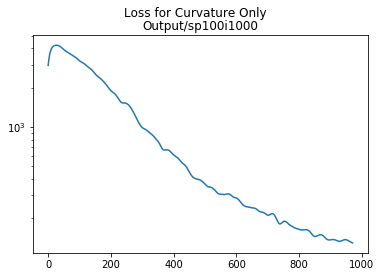

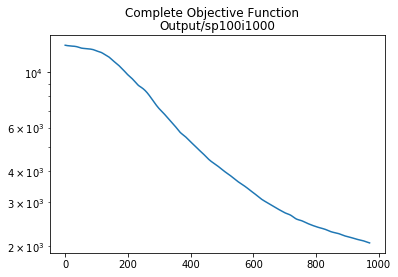

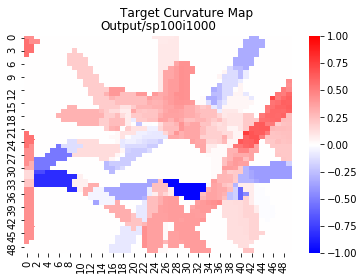

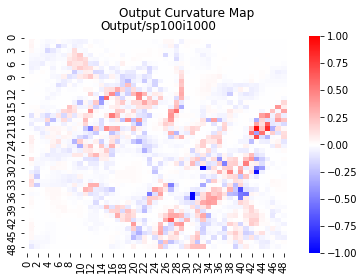

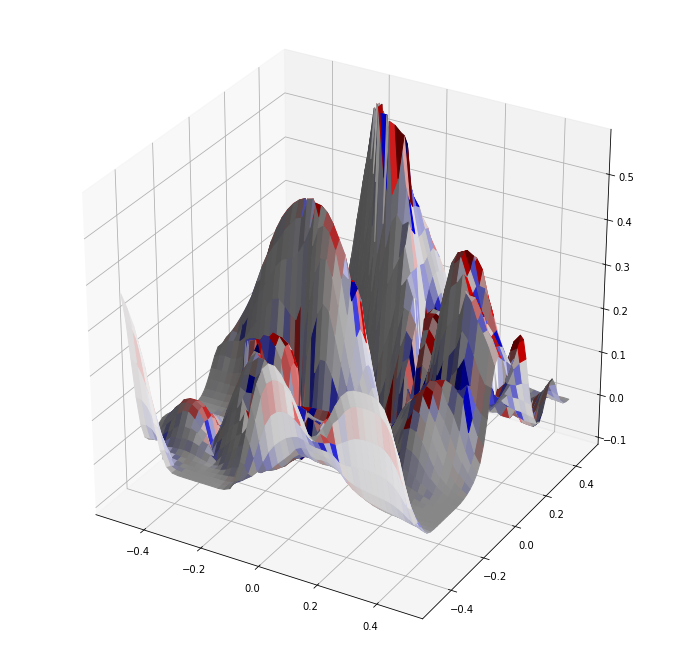

In [47]:
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 61451.56285172335
finished rate setting: rate: 0.0001 obj fn: 2080.9365494402064 complete obj fn: 32882.298161341256
step: 0, obj fn: 3362.7498987692743
step: 1 -- lowering rate to 9.09090909090909e-05
step: 2 -- lowering rate to 8.264462809917355e-05
step: 3 -- lowering rate to 7.513148009015777e-05
step: 4 -- lowering rate to 6.830134553650706e-05
step: 6 -- lowering rate to 6.20921323059155e-05
step: 7 -- lowering rate to 5.644739300537773e-05
step: 100, obj fn: 140.50868385264857
step: 200, obj fn: 133.20448123519026
step: 300, obj fn: 130.49356184333425
step: 400, obj fn: 129.13751624554598
step: 500, obj fn: 128.58134327525403
step: 553 -- lowering rate to 5.131581182307066e-05
step: 554 -- lowering rate to 4.665073802097332e-05
step: 555 -- lowering rate to 4.240976183724847e-05
step: 556 -- lowering rate to 3.8554328942953155e-05
step: 557 -- lowering rate to 3.504938994813923e-05
step: 558 -- loweri

step: 696 -- lowering rate to 6.181547720404416e-11
step: 697 -- lowering rate to 5.619588836731287e-11
step: 698 -- lowering rate to 5.1087171243011696e-11
step: 699 -- lowering rate to 4.6442882948192444e-11
step: 700 -- lowering rate to 4.222080268017495e-11
step: 701 -- lowering rate to 3.838254789106813e-11
step: 702 -- lowering rate to 3.489322535551648e-11
step: 703 -- lowering rate to 3.172111395956043e-11
step: 704 -- lowering rate to 2.8837376326873116e-11
step: 705 -- lowering rate to 2.621579666079374e-11
step: 706 -- lowering rate to 2.3832542418903398e-11
step: 707 -- lowering rate to 2.1665947653548543e-11
step: 708 -- lowering rate to 1.9696316048680493e-11
step: 709 -- lowering rate to 1.790574186243681e-11
step: 710 -- lowering rate to 1.6277947147669826e-11
step: 711 -- lowering rate to 1.479813377060893e-11
step: 712 -- lowering rate to 1.3452848882371755e-11
step: 713 -- lowering rate to 1.2229862620337958e-11
step: 714 -- lowering rate to 1.1118056927579962e-11
st

step: 854 -- lowering rate to 1.9608557968540955e-17
step: 855 -- lowering rate to 1.7825961789582685e-17
step: 856 -- lowering rate to 1.620541980871153e-17
step: 857 -- raising rate to 1.7825961789582685e-17
step: 858 -- lowering rate to 1.620541980871153e-17
step: 859 -- raising rate to 1.7825961789582685e-17
step: 860 -- lowering rate to 1.620541980871153e-17
step: 861 -- raising rate to 1.7825961789582685e-17
step: 862 -- lowering rate to 1.620541980871153e-17
step: 863 -- raising rate to 1.7825961789582685e-17
step: 864 -- lowering rate to 1.620541980871153e-17
step: 865 -- raising rate to 1.7825961789582685e-17
step: 866 -- lowering rate to 1.620541980871153e-17
step: 867 -- raising rate to 1.7825961789582685e-17
step: 868 -- lowering rate to 1.620541980871153e-17
step: 869 -- raising rate to 1.7825961789582685e-17
step: 870 -- lowering rate to 1.620541980871153e-17
step: 871 -- raising rate to 1.7825961789582685e-17
step: 872 -- lowering rate to 1.620541980871153e-17
step: 873 

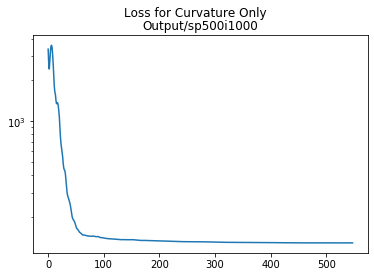

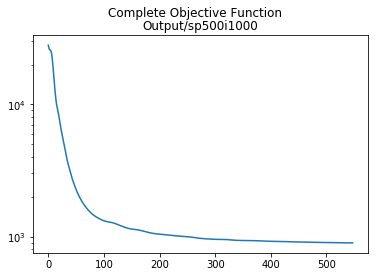

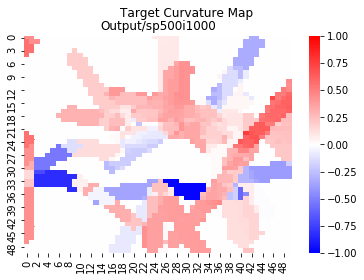

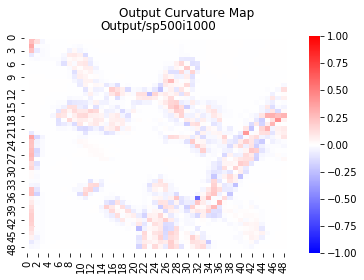

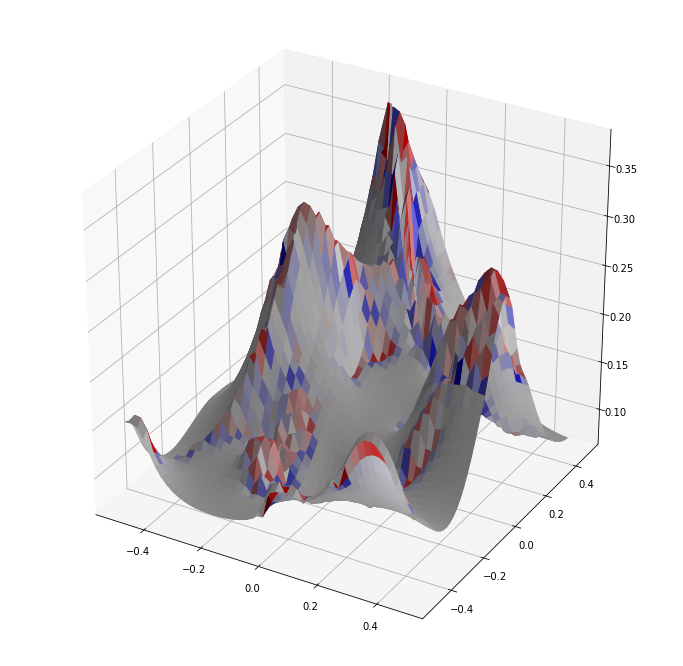

In [48]:
smooth_pen = 500
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 120849.35285745081
finished rate setting: rate: 0.0001 obj fn: 1485.7582970716355 complete obj fn: 40700.70728245485
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 6 -- lowering rate to 5.644739300537773e-05
step: 7 -- lowering rate to 5.131581182307066e-05
step: 8 -- lowering rate to 4.665073802097332e-05
step: 10 -- lowering rate to 4.240976183724847e-05
step: 100, obj fn: 140.31290470619575
step: 200, obj fn: 137.6886549879594
step: 300, obj fn: 136.1464092761657
step: 400, obj fn: 134.95532659080646
step: 500, obj fn: 134.34473636917318
step: 600, obj fn: 133.40467973145365
step: 700, obj fn: 132.68419213307226
step: 800, obj fn: 132.42682895640198
step: 900, obj fn: 132.3308406846836
Done: final erro

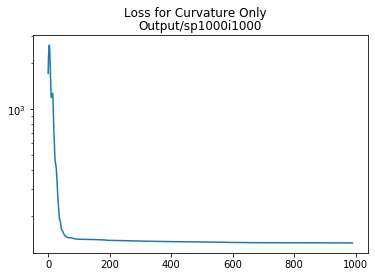

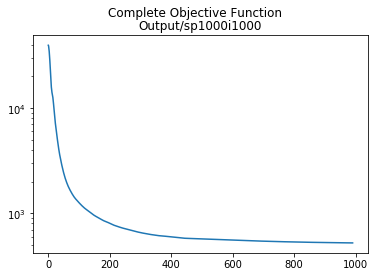

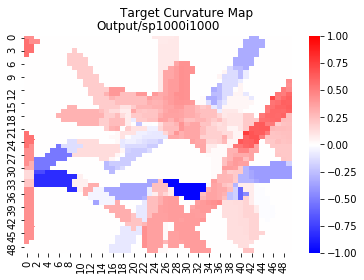

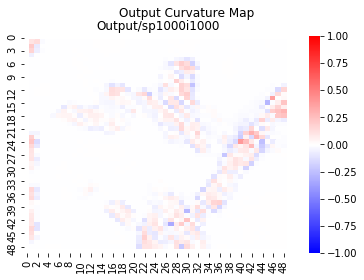

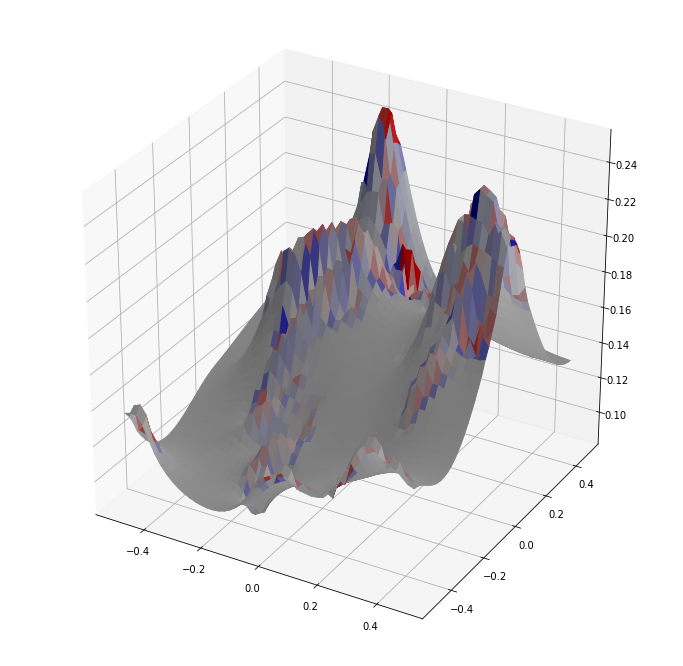

In [49]:
smooth_pen = 1000
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 239644.93286890571
finished rate setting: rate: 0.0001 obj fn: 8608.39002700864 complete obj fn: 175114.01690385758
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 5 -- lowering rate to 5.644739300537773e-05
step: 11 -- lowering rate to 5.131581182307066e-05
step: 100, obj fn: 144.63444540184773
step: 200, obj fn: 143.60365011614726
step: 300, obj fn: 143.4011585103185
step: 400, obj fn: 143.36879724810842
step: 500, obj fn: 143.36859425189851
step: 600, obj fn: 143.37293527892552
step: 700, obj fn: 143.3771662521855
step: 800, obj fn: 143.3822340452075
step: 900, obj fn: 143.38773519841146
Done: final error: 143.39066474396589


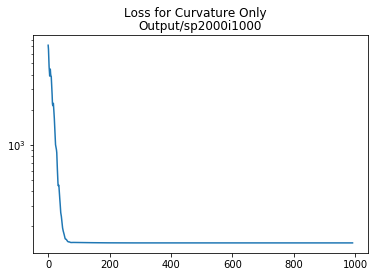

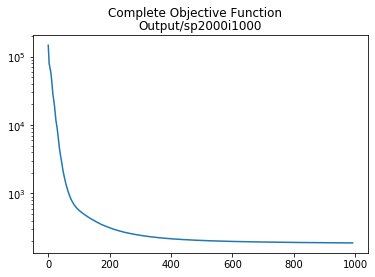

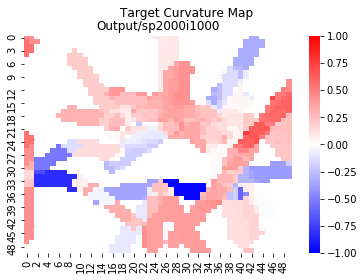

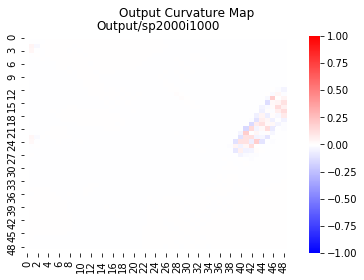

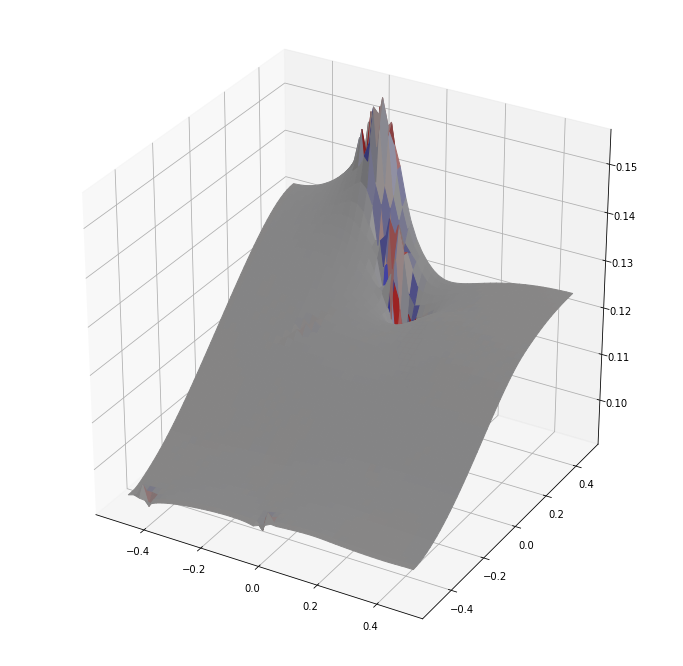

In [50]:
smooth_pen = 2000
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 596031.6729032705
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
finished rate setting: rate: 4.665073802097332e-05 obj fn: 11526.31804595961 complete obj fn: 579643.7306607077
step: 0 -- lowering rate to 4.240976183724847e-05
step: 1 -- lowering rate to 3.8554328942953155e-05
step: 2 -- lowering rate to 3.504938994813923e-05
step: 3 -- lowering rate to 3.1863081771035665e-05
step: 4 -- lowering rate to 2.8966437973668783e-05
step: 9 -- lowering rate to 2.633312543060798e-05
step: 11 -- lowering rate to 2.3939204936916344e-05
step: 100, obj fn: 145.20199064192877
step: 20

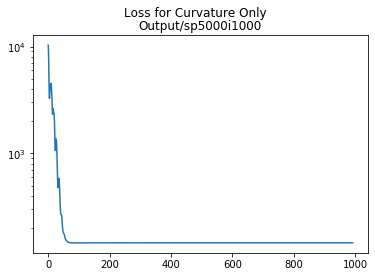

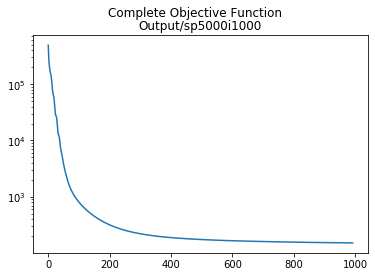

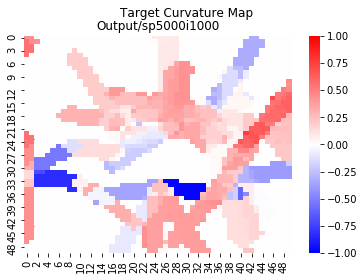

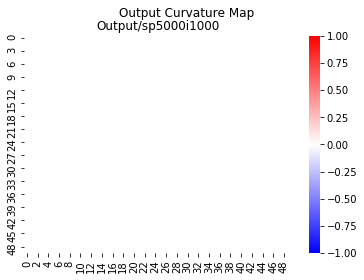

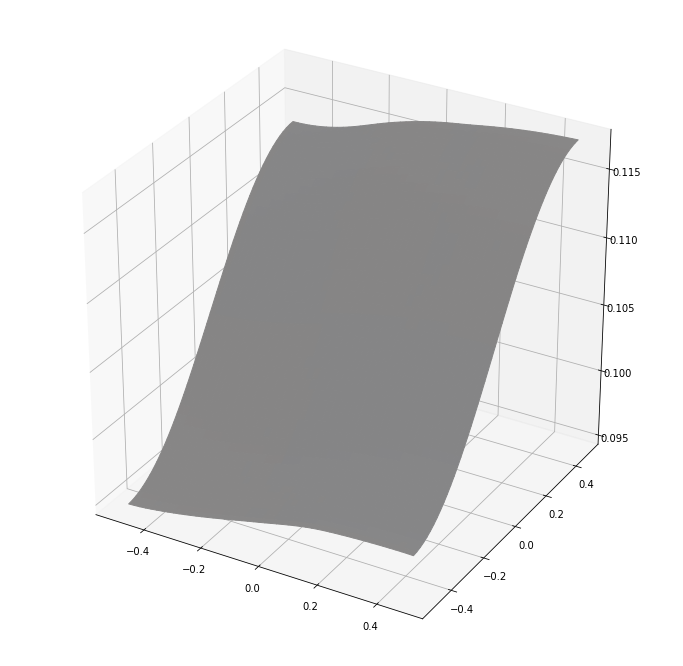

In [51]:
smooth_pen = 5000
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 1190009.572960545
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
setup: -- lowering rate to 3.1863081771035665e-05
setup: -- lowering rate to 2.8966437973668783e-05
setup: -- lowering rate to 2.633312543060798e-05
setup: -- lowering rate to 2.3939204936916344e-05
setup: -- lowering rate to 2.1762913579014857e-05
finished rate setting: rate: 2.1762913579014857e-05 obj fn: 9752.112267717805 complete obj fn: 908988.4269913494
ste

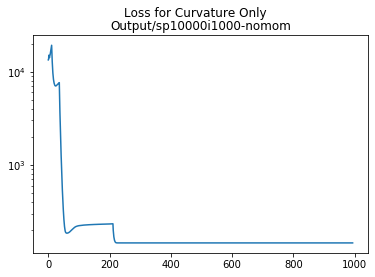

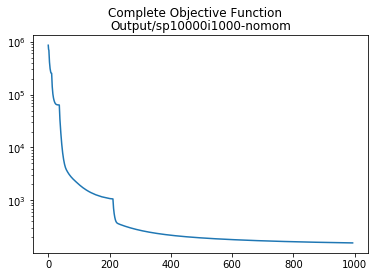

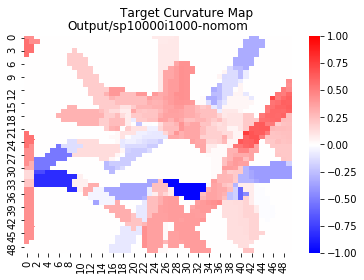

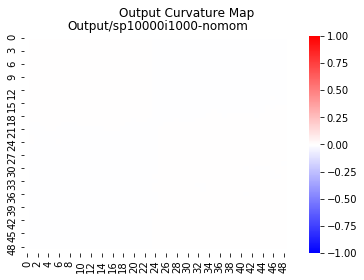

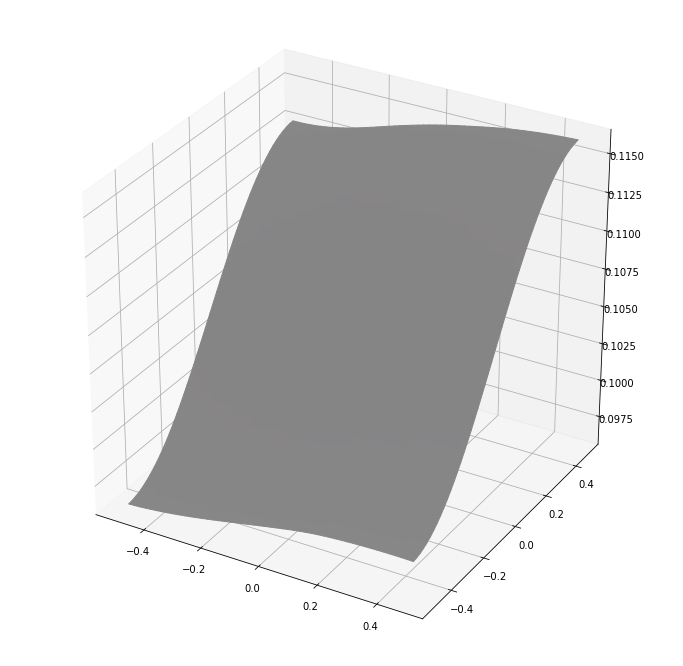

In [52]:
smooth_pen = 10000
niter = 1000
momentum = 0
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}-nomom'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 2065.6524039970345
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
finished rate setting: rate: 6.830134553650706e-05 obj fn: 1948.0921220090488 complete obj fn: 1959.5217888250427
step: 0 -- lowering rate to 6.20921323059155e-05
step: 1 -- lowering rate to 5.644739300537773e-05
step: 2 -- lowering rate to 5.131581182307066e-05
step: 3 -- lowering rate to 4.665073802097332e-05
step: 4 -- lowering rate to 4.240976183724847e-05
step: 7 -- lowering rate to 3.8554328942953155e-05
step: 44 -- lowering rate to 3.504938994813923e-05
step: 54 -- lowering rate to 3.1863081771035665e-05
step: 57 -- lowering rate to 2.8966437973668783e-05
step: 62 -- lowering rate to 2.633312543060798e-05
step: 74 -- lowering rate to 2.3939204936916344e-05
step: 76 -- lowering rate to 2.1762

step: 854 -- lowering rate to 6.799702492444859e-11
step: 855 -- lowering rate to 6.181547720404416e-11
step: 856 -- lowering rate to 5.619588836731287e-11
step: 857 -- lowering rate to 5.1087171243011696e-11
step: 858 -- lowering rate to 4.6442882948192444e-11
step: 859 -- lowering rate to 4.222080268017495e-11
step: 860 -- lowering rate to 3.838254789106813e-11
step: 861 -- lowering rate to 3.489322535551648e-11
step: 862 -- lowering rate to 3.172111395956043e-11
step: 863 -- lowering rate to 2.8837376326873116e-11
step: 864 -- lowering rate to 2.621579666079374e-11
step: 865 -- lowering rate to 2.3832542418903398e-11
step: 866 -- lowering rate to 2.1665947653548543e-11
step: 867 -- lowering rate to 1.9696316048680493e-11
step: 868 -- lowering rate to 1.790574186243681e-11
step: 869 -- lowering rate to 1.6277947147669826e-11
step: 870 -- lowering rate to 1.479813377060893e-11
step: 871 -- lowering rate to 1.3452848882371755e-11
step: 872 -- lowering rate to 1.2229862620337958e-11
ste

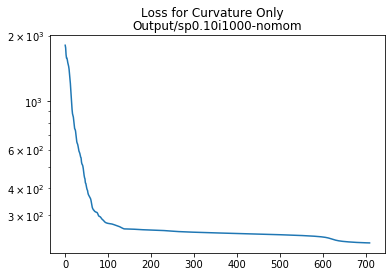

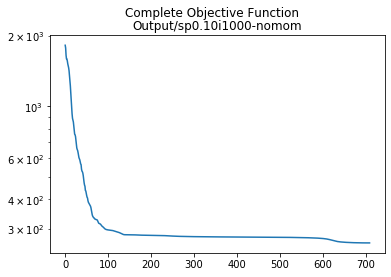

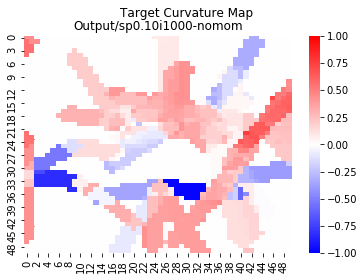

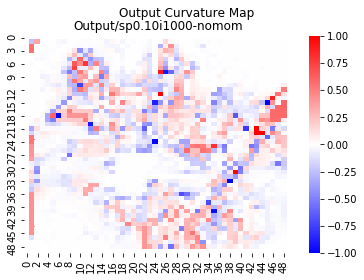

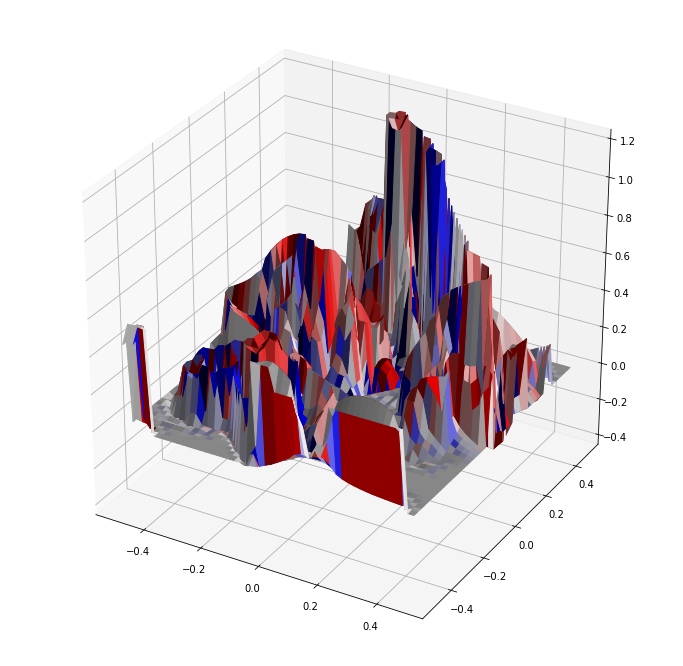

In [36]:
smooth_pen = 0.1
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:.2f}i{:d}-nomom'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 13933.33084714138
finished rate setting: rate: 0.0001 obj fn: 2772.812652086687 complete obj fn: 12855.628823857507
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 8 -- lowering rate to 7.513148009015777e-05
step: 100, obj fn: 131.2280247432367
step: 200, obj fn: 114.28470989986508
step: 300, obj fn: 112.98895594911386
step: 391 -- lowering rate to 6.830134553650706e-05
step: 400, obj fn: 111.81440986688312
step: 500, obj fn: 111.65389419542147
step: 581 -- lowering rate to 6.20921323059155e-05
step: 600, obj fn: 111.19666314588844
step: 686 -- lowering rate to 5.644739300537773e-05
step: 688 -- lowering rate to 5.131581182307066e-05
step: 689 -- lowering rate to 4.665073802097332e-05
step: 690 -- lowering rate to 4.240976183724847e-05
step: 692 -- lowering rate to 3.8554328942953155e-05
step: 693 -- lowering rate to 3.504938994813923e-05
step: 695 -- 

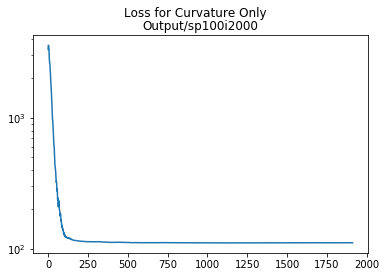

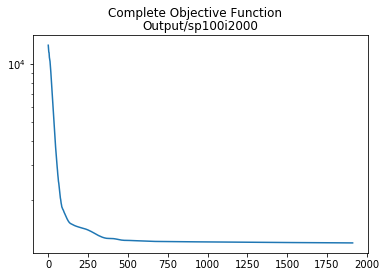

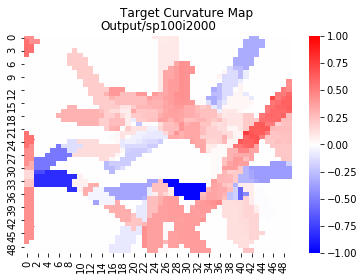

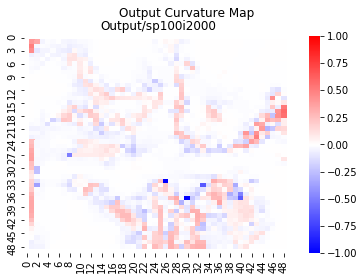

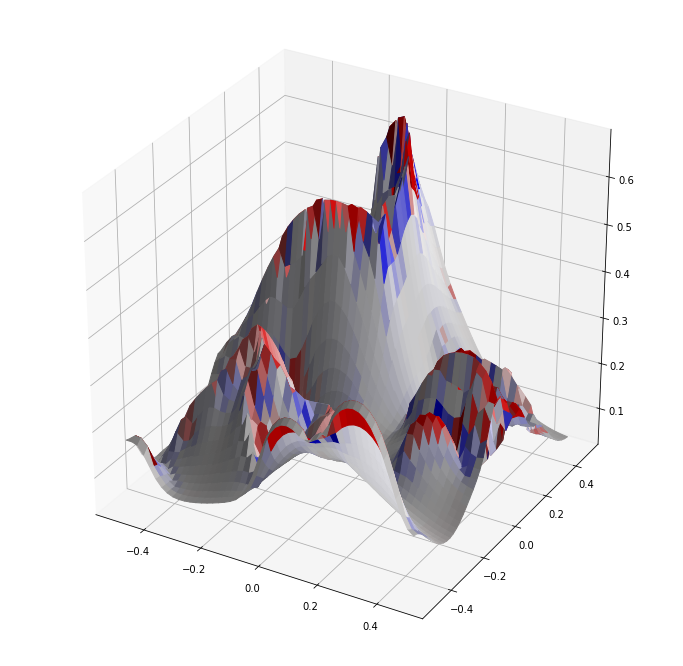

In [37]:
smooth_pen = 100
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 3241.728646110438
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
finished rate setting: rate: 6.830134553650706e-05 obj fn: 1940.289303217914 complete obj fn: 3074.040282097381
step: 0 -- lowering rate to 6.20921323059155e-05
step: 1 -- lowering rate to 5.644739300537773e-05
step: 2 -- lowering rate to 5.131581182307066e-05
step: 3 -- lowering rate to 4.665073802097332e-05
step: 4 -- lowering rate to 4.240976183724847e-05
step: 23 -- lowering rate to 3.8554328942953155e-05
step: 35 -- lowering rate to 3.504938994813923e-05
step: 38 -- lowering rate to 3.1863081771035665e-05
step: 40 -- lowering rate to 2.8966437973668783e-05
step: 42 -- lowering rate to 2.633312543060798e-05
step: 45 -- lowering rate to 2.3939204936916344e-05
step: 48 -- lowering rate to 2.176291

step: 208 -- lowering rate to 3.838254789106813e-11
step: 209 -- lowering rate to 3.489322535551648e-11
step: 210 -- lowering rate to 3.172111395956043e-11
step: 211 -- lowering rate to 2.8837376326873116e-11
step: 212 -- lowering rate to 2.621579666079374e-11
step: 213 -- lowering rate to 2.3832542418903398e-11
step: 214 -- lowering rate to 2.1665947653548543e-11
step: 215 -- lowering rate to 1.9696316048680493e-11
step: 216 -- lowering rate to 1.790574186243681e-11
step: 217 -- lowering rate to 1.6277947147669826e-11
step: 218 -- lowering rate to 1.479813377060893e-11
step: 219 -- lowering rate to 1.3452848882371755e-11
step: 220 -- lowering rate to 1.2229862620337958e-11
step: 221 -- lowering rate to 1.1118056927579962e-11
step: 222 -- lowering rate to 1.0107324479618146e-11
step: 223 -- lowering rate to 9.18847679965286e-12
step: 224 -- lowering rate to 8.353160726957144e-12
step: 225 -- lowering rate to 7.593782479051949e-12
step: 226 -- lowering rate to 6.903438617319953e-12
step

step: 365 -- raising rate to 6.769406023055247e-17
step: 366 -- lowering rate to 6.15400547550477e-17
step: 367 -- raising rate to 6.769406023055247e-17
step: 368 -- lowering rate to 6.15400547550477e-17
step: 369 -- raising rate to 6.769406023055247e-17
step: 370 -- lowering rate to 6.15400547550477e-17
step: 371 -- raising rate to 6.769406023055247e-17
step: 372 -- lowering rate to 6.15400547550477e-17
step: 373 -- raising rate to 6.769406023055247e-17
step: 374 -- lowering rate to 6.15400547550477e-17
step: 375 -- raising rate to 6.769406023055247e-17
step: 376 -- lowering rate to 6.15400547550477e-17
step: 377 -- raising rate to 6.769406023055247e-17
step: 378 -- lowering rate to 6.15400547550477e-17
step: 379 -- raising rate to 6.769406023055247e-17
step: 380 -- lowering rate to 6.15400547550477e-17
step: 381 -- raising rate to 6.769406023055247e-17
step: 382 -- lowering rate to 6.15400547550477e-17
step: 383 -- raising rate to 6.769406023055247e-17
step: 384 -- lowering rate to 6

step: 526 -- lowering rate to 6.15400547550477e-17
step: 527 -- raising rate to 6.769406023055247e-17
step: 528 -- lowering rate to 6.15400547550477e-17
step: 529 -- raising rate to 6.769406023055247e-17
step: 530 -- lowering rate to 6.15400547550477e-17
step: 531 -- raising rate to 6.769406023055247e-17
step: 532 -- lowering rate to 6.15400547550477e-17
step: 533 -- raising rate to 6.769406023055247e-17
step: 534 -- lowering rate to 6.15400547550477e-17
step: 535 -- raising rate to 6.769406023055247e-17
step: 536 -- lowering rate to 6.15400547550477e-17
step: 537 -- raising rate to 6.769406023055247e-17
step: 538 -- lowering rate to 6.15400547550477e-17
step: 539 -- raising rate to 6.769406023055247e-17
step: 540 -- lowering rate to 6.15400547550477e-17
step: 541 -- raising rate to 6.769406023055247e-17
step: 542 -- lowering rate to 6.15400547550477e-17
step: 543 -- raising rate to 6.769406023055247e-17
step: 544 -- lowering rate to 6.15400547550477e-17
step: 545 -- raising rate to 6.

step: 687 -- raising rate to 6.769406023055247e-17
step: 688 -- lowering rate to 6.15400547550477e-17
step: 689 -- raising rate to 6.769406023055247e-17
step: 690 -- lowering rate to 6.15400547550477e-17
step: 691 -- raising rate to 6.769406023055247e-17
step: 692 -- lowering rate to 6.15400547550477e-17
step: 693 -- raising rate to 6.769406023055247e-17
step: 694 -- lowering rate to 6.15400547550477e-17
step: 695 -- raising rate to 6.769406023055247e-17
step: 696 -- lowering rate to 6.15400547550477e-17
step: 697 -- raising rate to 6.769406023055247e-17
step: 698 -- lowering rate to 6.15400547550477e-17
step: 699 -- raising rate to 6.769406023055247e-17
step: 700 -- lowering rate to 6.15400547550477e-17
step: 701 -- raising rate to 6.769406023055247e-17
step: 702 -- lowering rate to 6.15400547550477e-17
step: 703 -- raising rate to 6.769406023055247e-17
step: 704 -- lowering rate to 6.15400547550477e-17
step: 705 -- raising rate to 6.769406023055247e-17
step: 706 -- lowering rate to 6

step: 848 -- lowering rate to 6.15400547550477e-17
step: 849 -- raising rate to 6.769406023055247e-17
step: 850 -- lowering rate to 6.15400547550477e-17
step: 851 -- raising rate to 6.769406023055247e-17
step: 852 -- lowering rate to 6.15400547550477e-17
step: 853 -- raising rate to 6.769406023055247e-17
step: 854 -- lowering rate to 6.15400547550477e-17
step: 855 -- raising rate to 6.769406023055247e-17
step: 856 -- lowering rate to 6.15400547550477e-17
step: 857 -- raising rate to 6.769406023055247e-17
step: 858 -- lowering rate to 6.15400547550477e-17
step: 859 -- raising rate to 6.769406023055247e-17
step: 860 -- lowering rate to 6.15400547550477e-17
step: 861 -- raising rate to 6.769406023055247e-17
step: 862 -- lowering rate to 6.15400547550477e-17
step: 863 -- raising rate to 6.769406023055247e-17
step: 864 -- lowering rate to 6.15400547550477e-17
step: 865 -- raising rate to 6.769406023055247e-17
step: 866 -- lowering rate to 6.15400547550477e-17
step: 867 -- raising rate to 6.

step: 1009 -- raising rate to 6.769406023055247e-17
step: 1010 -- lowering rate to 6.15400547550477e-17
step: 1011 -- raising rate to 6.769406023055247e-17
step: 1012 -- lowering rate to 6.15400547550477e-17
step: 1013 -- raising rate to 6.769406023055247e-17
step: 1014 -- lowering rate to 6.15400547550477e-17
step: 1015 -- raising rate to 6.769406023055247e-17
step: 1016 -- lowering rate to 6.15400547550477e-17
step: 1017 -- raising rate to 6.769406023055247e-17
step: 1018 -- lowering rate to 6.15400547550477e-17
step: 1019 -- raising rate to 6.769406023055247e-17
step: 1020 -- lowering rate to 6.15400547550477e-17
step: 1021 -- raising rate to 6.769406023055247e-17
step: 1022 -- lowering rate to 6.15400547550477e-17
step: 1023 -- raising rate to 6.769406023055247e-17
step: 1024 -- lowering rate to 6.15400547550477e-17
step: 1025 -- raising rate to 6.769406023055247e-17
step: 1026 -- lowering rate to 6.15400547550477e-17
step: 1027 -- raising rate to 6.769406023055247e-17
step: 1028 -

step: 1167 -- raising rate to 6.769406023055247e-17
step: 1168 -- lowering rate to 6.15400547550477e-17
step: 1169 -- raising rate to 6.769406023055247e-17
step: 1170 -- lowering rate to 6.15400547550477e-17
step: 1171 -- raising rate to 6.769406023055247e-17
step: 1172 -- lowering rate to 6.15400547550477e-17
step: 1173 -- raising rate to 6.769406023055247e-17
step: 1174 -- lowering rate to 6.15400547550477e-17
step: 1175 -- raising rate to 6.769406023055247e-17
step: 1176 -- lowering rate to 6.15400547550477e-17
step: 1177 -- raising rate to 6.769406023055247e-17
step: 1178 -- lowering rate to 6.15400547550477e-17
step: 1179 -- raising rate to 6.769406023055247e-17
step: 1180 -- lowering rate to 6.15400547550477e-17
step: 1181 -- raising rate to 6.769406023055247e-17
step: 1182 -- lowering rate to 6.15400547550477e-17
step: 1183 -- raising rate to 6.769406023055247e-17
step: 1184 -- lowering rate to 6.15400547550477e-17
step: 1185 -- raising rate to 6.769406023055247e-17
step: 1186 -

step: 1325 -- raising rate to 6.769406023055247e-17
step: 1326 -- lowering rate to 6.15400547550477e-17
step: 1327 -- raising rate to 6.769406023055247e-17
step: 1328 -- lowering rate to 6.15400547550477e-17
step: 1329 -- raising rate to 6.769406023055247e-17
step: 1330 -- lowering rate to 6.15400547550477e-17
step: 1331 -- raising rate to 6.769406023055247e-17
step: 1332 -- lowering rate to 6.15400547550477e-17
step: 1333 -- raising rate to 6.769406023055247e-17
step: 1334 -- lowering rate to 6.15400547550477e-17
step: 1335 -- raising rate to 6.769406023055247e-17
step: 1336 -- lowering rate to 6.15400547550477e-17
step: 1337 -- raising rate to 6.769406023055247e-17
step: 1338 -- lowering rate to 6.15400547550477e-17
step: 1339 -- raising rate to 6.769406023055247e-17
step: 1340 -- lowering rate to 6.15400547550477e-17
step: 1341 -- raising rate to 6.769406023055247e-17
step: 1342 -- lowering rate to 6.15400547550477e-17
step: 1343 -- raising rate to 6.769406023055247e-17
step: 1344 -

step: 1483 -- raising rate to 6.769406023055247e-17
step: 1484 -- lowering rate to 6.15400547550477e-17
step: 1485 -- raising rate to 6.769406023055247e-17
step: 1486 -- lowering rate to 6.15400547550477e-17
step: 1487 -- raising rate to 6.769406023055247e-17
step: 1488 -- lowering rate to 6.15400547550477e-17
step: 1489 -- raising rate to 6.769406023055247e-17
step: 1490 -- lowering rate to 6.15400547550477e-17
step: 1491 -- raising rate to 6.769406023055247e-17
step: 1492 -- lowering rate to 6.15400547550477e-17
step: 1493 -- raising rate to 6.769406023055247e-17
step: 1494 -- lowering rate to 6.15400547550477e-17
step: 1495 -- raising rate to 6.769406023055247e-17
step: 1496 -- lowering rate to 6.15400547550477e-17
step: 1497 -- raising rate to 6.769406023055247e-17
step: 1498 -- lowering rate to 6.15400547550477e-17
step: 1499 -- raising rate to 6.769406023055247e-17
step: 1500 -- lowering rate to 6.15400547550477e-17
step: 1501 -- raising rate to 6.769406023055247e-17
step: 1502 -

step: 1641 -- raising rate to 6.769406023055247e-17
step: 1642 -- lowering rate to 6.15400547550477e-17
step: 1643 -- raising rate to 6.769406023055247e-17
step: 1644 -- lowering rate to 6.15400547550477e-17
step: 1645 -- raising rate to 6.769406023055247e-17
step: 1646 -- lowering rate to 6.15400547550477e-17
step: 1647 -- raising rate to 6.769406023055247e-17
step: 1648 -- lowering rate to 6.15400547550477e-17
step: 1649 -- raising rate to 6.769406023055247e-17
step: 1650 -- lowering rate to 6.15400547550477e-17
step: 1651 -- raising rate to 6.769406023055247e-17
step: 1652 -- lowering rate to 6.15400547550477e-17
step: 1653 -- raising rate to 6.769406023055247e-17
step: 1654 -- lowering rate to 6.15400547550477e-17
step: 1655 -- raising rate to 6.769406023055247e-17
step: 1656 -- lowering rate to 6.15400547550477e-17
step: 1657 -- raising rate to 6.769406023055247e-17
step: 1658 -- lowering rate to 6.15400547550477e-17
step: 1659 -- raising rate to 6.769406023055247e-17
step: 1660 -

step: 1799 -- raising rate to 6.769406023055247e-17
step: 1800 -- lowering rate to 6.15400547550477e-17
step: 1801 -- raising rate to 6.769406023055247e-17
step: 1802 -- lowering rate to 6.15400547550477e-17
step: 1803 -- raising rate to 6.769406023055247e-17
step: 1804 -- lowering rate to 6.15400547550477e-17
step: 1805 -- raising rate to 6.769406023055247e-17
step: 1806 -- lowering rate to 6.15400547550477e-17
step: 1807 -- raising rate to 6.769406023055247e-17
step: 1808 -- lowering rate to 6.15400547550477e-17
step: 1809 -- raising rate to 6.769406023055247e-17
step: 1810 -- lowering rate to 6.15400547550477e-17
step: 1811 -- raising rate to 6.769406023055247e-17
step: 1812 -- lowering rate to 6.15400547550477e-17
step: 1813 -- raising rate to 6.769406023055247e-17
step: 1814 -- lowering rate to 6.15400547550477e-17
step: 1815 -- raising rate to 6.769406023055247e-17
step: 1816 -- lowering rate to 6.15400547550477e-17
step: 1817 -- raising rate to 6.769406023055247e-17
step: 1818 -

step: 1957 -- raising rate to 6.769406023055247e-17
step: 1958 -- lowering rate to 6.15400547550477e-17
step: 1959 -- raising rate to 6.769406023055247e-17
step: 1960 -- lowering rate to 6.15400547550477e-17
step: 1961 -- raising rate to 6.769406023055247e-17
step: 1962 -- lowering rate to 6.15400547550477e-17
step: 1963 -- raising rate to 6.769406023055247e-17
step: 1964 -- lowering rate to 6.15400547550477e-17
step: 1965 -- raising rate to 6.769406023055247e-17
step: 1966 -- lowering rate to 6.15400547550477e-17
step: 1967 -- raising rate to 6.769406023055247e-17
step: 1968 -- lowering rate to 6.15400547550477e-17
step: 1969 -- raising rate to 6.769406023055247e-17
step: 1970 -- lowering rate to 6.15400547550477e-17
step: 1971 -- raising rate to 6.769406023055247e-17
step: 1972 -- lowering rate to 6.15400547550477e-17
step: 1973 -- raising rate to 6.769406023055247e-17
step: 1974 -- lowering rate to 6.15400547550477e-17
step: 1975 -- raising rate to 6.769406023055247e-17
step: 1976 -

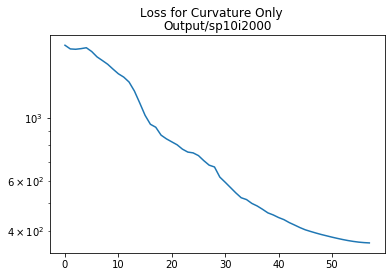

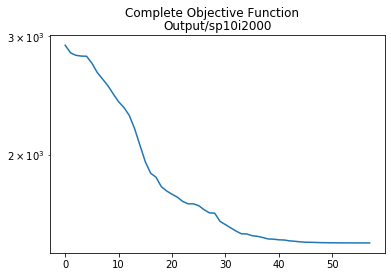

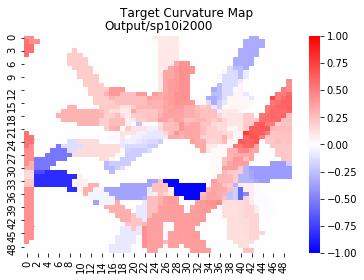

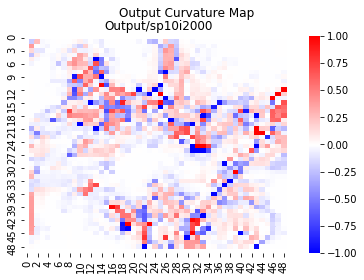

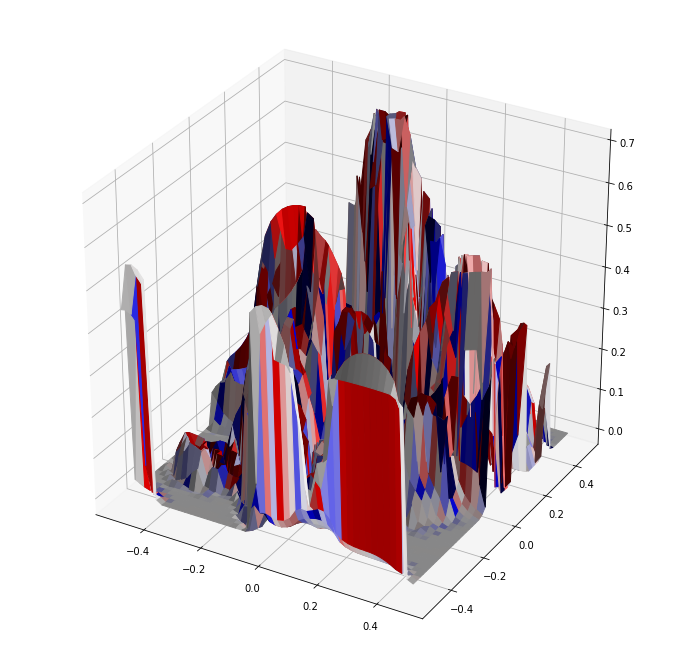

In [38]:
smooth_pen = 10
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 7993.551846568635
setup: -- lowering rate to 9.09090909090909e-05
finished rate setting: rate: 9.09090909090909e-05 obj fn: 2588.2091062331274 complete obj fn: 7974.182382131195
step: 0 -- lowering rate to 8.264462809917355e-05
step: 1 -- lowering rate to 7.513148009015777e-05
step: 2 -- lowering rate to 6.830134553650706e-05
step: 26 -- lowering rate to 6.20921323059155e-05
step: 29 -- lowering rate to 5.644739300537773e-05
step: 32 -- lowering rate to 5.131581182307066e-05
step: 35 -- lowering rate to 4.665073802097332e-05
step: 38 -- lowering rate to 4.240976183724847e-05
step: 42 -- lowering rate to 3.8554328942953155e-05
step: 44 -- lowering rate to 3.504938994813923e-05
step: 46 -- lowering rate to 3.1863081771035665e-05
step: 48 -- lowering rate to 2.8966437973668783e-05
step: 51 -- lowering rate to 2.633312543060798e-05
step: 54 -- lowering rate to 2.3939204936916344e-05
step: 56 -- lowering rate to 

step: 213 -- lowering rate to 3.838254789106813e-11
step: 214 -- lowering rate to 3.489322535551648e-11
step: 215 -- lowering rate to 3.172111395956043e-11
step: 216 -- lowering rate to 2.8837376326873116e-11
step: 217 -- lowering rate to 2.621579666079374e-11
step: 218 -- lowering rate to 2.3832542418903398e-11
step: 219 -- lowering rate to 2.1665947653548543e-11
step: 220 -- lowering rate to 1.9696316048680493e-11
step: 221 -- lowering rate to 1.790574186243681e-11
step: 222 -- lowering rate to 1.6277947147669826e-11
step: 223 -- lowering rate to 1.479813377060893e-11
step: 224 -- lowering rate to 1.3452848882371755e-11
step: 225 -- lowering rate to 1.2229862620337958e-11
step: 226 -- lowering rate to 1.1118056927579962e-11
step: 227 -- lowering rate to 1.0107324479618146e-11
step: 228 -- lowering rate to 9.18847679965286e-12
step: 229 -- lowering rate to 8.353160726957144e-12
step: 230 -- lowering rate to 7.593782479051949e-12
step: 231 -- lowering rate to 6.903438617319953e-12
step

step: 370 -- lowering rate to 3.763733774964352e-16
step: 371 -- raising rate to 4.1401071524607877e-16
step: 372 -- lowering rate to 3.763733774964352e-16
step: 373 -- raising rate to 4.1401071524607877e-16
step: 374 -- lowering rate to 3.763733774964352e-16
step: 375 -- raising rate to 4.1401071524607877e-16
step: 376 -- lowering rate to 3.763733774964352e-16
step: 377 -- raising rate to 4.1401071524607877e-16
step: 378 -- lowering rate to 3.763733774964352e-16
step: 379 -- raising rate to 4.1401071524607877e-16
step: 380 -- lowering rate to 3.763733774964352e-16
step: 381 -- raising rate to 4.1401071524607877e-16
step: 382 -- lowering rate to 3.763733774964352e-16
step: 383 -- raising rate to 4.1401071524607877e-16
step: 384 -- lowering rate to 3.763733774964352e-16
step: 385 -- raising rate to 4.1401071524607877e-16
step: 386 -- lowering rate to 3.763733774964352e-16
step: 387 -- raising rate to 4.1401071524607877e-16
step: 388 -- lowering rate to 3.763733774964352e-16
step: 389 --

step: 528 -- lowering rate to 3.763733774964352e-16
step: 529 -- raising rate to 4.1401071524607877e-16
step: 530 -- lowering rate to 3.763733774964352e-16
step: 531 -- raising rate to 4.1401071524607877e-16
step: 532 -- lowering rate to 3.763733774964352e-16
step: 533 -- raising rate to 4.1401071524607877e-16
step: 534 -- lowering rate to 3.763733774964352e-16
step: 535 -- raising rate to 4.1401071524607877e-16
step: 536 -- lowering rate to 3.763733774964352e-16
step: 537 -- raising rate to 4.1401071524607877e-16
step: 538 -- lowering rate to 3.763733774964352e-16
step: 539 -- raising rate to 4.1401071524607877e-16
step: 540 -- lowering rate to 3.763733774964352e-16
step: 541 -- raising rate to 4.1401071524607877e-16
step: 542 -- lowering rate to 3.763733774964352e-16
step: 543 -- raising rate to 4.1401071524607877e-16
step: 544 -- lowering rate to 3.763733774964352e-16
step: 545 -- raising rate to 4.1401071524607877e-16
step: 546 -- lowering rate to 3.763733774964352e-16
step: 547 --

step: 686 -- lowering rate to 3.763733774964352e-16
step: 687 -- raising rate to 4.1401071524607877e-16
step: 688 -- lowering rate to 3.763733774964352e-16
step: 689 -- raising rate to 4.1401071524607877e-16
step: 690 -- lowering rate to 3.763733774964352e-16
step: 691 -- raising rate to 4.1401071524607877e-16
step: 692 -- lowering rate to 3.763733774964352e-16
step: 693 -- raising rate to 4.1401071524607877e-16
step: 694 -- lowering rate to 3.763733774964352e-16
step: 695 -- raising rate to 4.1401071524607877e-16
step: 696 -- lowering rate to 3.763733774964352e-16
step: 697 -- raising rate to 4.1401071524607877e-16
step: 698 -- lowering rate to 3.763733774964352e-16
step: 699 -- raising rate to 4.1401071524607877e-16
step: 700 -- lowering rate to 3.763733774964352e-16
step: 701 -- raising rate to 4.1401071524607877e-16
step: 702 -- lowering rate to 3.763733774964352e-16
step: 703 -- raising rate to 4.1401071524607877e-16
step: 704 -- lowering rate to 3.763733774964352e-16
step: 705 --

step: 844 -- lowering rate to 3.763733774964352e-16
step: 845 -- raising rate to 4.1401071524607877e-16
step: 846 -- lowering rate to 3.763733774964352e-16
step: 847 -- raising rate to 4.1401071524607877e-16
step: 848 -- lowering rate to 3.763733774964352e-16
step: 849 -- raising rate to 4.1401071524607877e-16
step: 850 -- lowering rate to 3.763733774964352e-16
step: 851 -- raising rate to 4.1401071524607877e-16
step: 852 -- lowering rate to 3.763733774964352e-16
step: 853 -- raising rate to 4.1401071524607877e-16
step: 854 -- lowering rate to 3.763733774964352e-16
step: 855 -- raising rate to 4.1401071524607877e-16
step: 856 -- lowering rate to 3.763733774964352e-16
step: 857 -- raising rate to 4.1401071524607877e-16
step: 858 -- lowering rate to 3.763733774964352e-16
step: 859 -- raising rate to 4.1401071524607877e-16
step: 860 -- lowering rate to 3.763733774964352e-16
step: 861 -- raising rate to 4.1401071524607877e-16
step: 862 -- lowering rate to 3.763733774964352e-16
step: 863 --

step: 1002 -- lowering rate to 3.763733774964352e-16
step: 1003 -- raising rate to 4.1401071524607877e-16
step: 1004 -- lowering rate to 3.763733774964352e-16
step: 1005 -- raising rate to 4.1401071524607877e-16
step: 1006 -- lowering rate to 3.763733774964352e-16
step: 1007 -- raising rate to 4.1401071524607877e-16
step: 1008 -- lowering rate to 3.763733774964352e-16
step: 1009 -- raising rate to 4.1401071524607877e-16
step: 1010 -- lowering rate to 3.763733774964352e-16
step: 1011 -- raising rate to 4.1401071524607877e-16
step: 1012 -- lowering rate to 3.763733774964352e-16
step: 1013 -- raising rate to 4.1401071524607877e-16
step: 1014 -- lowering rate to 3.763733774964352e-16
step: 1015 -- raising rate to 4.1401071524607877e-16
step: 1016 -- lowering rate to 3.763733774964352e-16
step: 1017 -- raising rate to 4.1401071524607877e-16
step: 1018 -- lowering rate to 3.763733774964352e-16
step: 1019 -- raising rate to 4.1401071524607877e-16
step: 1020 -- lowering rate to 3.7637337749643

step: 1157 -- raising rate to 4.1401071524607877e-16
step: 1158 -- lowering rate to 3.763733774964352e-16
step: 1159 -- raising rate to 4.1401071524607877e-16
step: 1160 -- lowering rate to 3.763733774964352e-16
step: 1161 -- raising rate to 4.1401071524607877e-16
step: 1162 -- lowering rate to 3.763733774964352e-16
step: 1163 -- raising rate to 4.1401071524607877e-16
step: 1164 -- lowering rate to 3.763733774964352e-16
step: 1165 -- raising rate to 4.1401071524607877e-16
step: 1166 -- lowering rate to 3.763733774964352e-16
step: 1167 -- raising rate to 4.1401071524607877e-16
step: 1168 -- lowering rate to 3.763733774964352e-16
step: 1169 -- raising rate to 4.1401071524607877e-16
step: 1170 -- lowering rate to 3.763733774964352e-16
step: 1171 -- raising rate to 4.1401071524607877e-16
step: 1172 -- lowering rate to 3.763733774964352e-16
step: 1173 -- raising rate to 4.1401071524607877e-16
step: 1174 -- lowering rate to 3.763733774964352e-16
step: 1175 -- raising rate to 4.14010715246078

step: 1312 -- lowering rate to 3.763733774964352e-16
step: 1313 -- raising rate to 4.1401071524607877e-16
step: 1314 -- lowering rate to 3.763733774964352e-16
step: 1315 -- raising rate to 4.1401071524607877e-16
step: 1316 -- lowering rate to 3.763733774964352e-16
step: 1317 -- raising rate to 4.1401071524607877e-16
step: 1318 -- lowering rate to 3.763733774964352e-16
step: 1319 -- raising rate to 4.1401071524607877e-16
step: 1320 -- lowering rate to 3.763733774964352e-16
step: 1321 -- raising rate to 4.1401071524607877e-16
step: 1322 -- lowering rate to 3.763733774964352e-16
step: 1323 -- raising rate to 4.1401071524607877e-16
step: 1324 -- lowering rate to 3.763733774964352e-16
step: 1325 -- raising rate to 4.1401071524607877e-16
step: 1326 -- lowering rate to 3.763733774964352e-16
step: 1327 -- raising rate to 4.1401071524607877e-16
step: 1328 -- lowering rate to 3.763733774964352e-16
step: 1329 -- raising rate to 4.1401071524607877e-16
step: 1330 -- lowering rate to 3.7637337749643

step: 1467 -- raising rate to 4.1401071524607877e-16
step: 1468 -- lowering rate to 3.763733774964352e-16
step: 1469 -- raising rate to 4.1401071524607877e-16
step: 1470 -- lowering rate to 3.763733774964352e-16
step: 1471 -- raising rate to 4.1401071524607877e-16
step: 1472 -- lowering rate to 3.763733774964352e-16
step: 1473 -- raising rate to 4.1401071524607877e-16
step: 1474 -- lowering rate to 3.763733774964352e-16
step: 1475 -- raising rate to 4.1401071524607877e-16
step: 1476 -- lowering rate to 3.763733774964352e-16
step: 1477 -- raising rate to 4.1401071524607877e-16
step: 1478 -- lowering rate to 3.763733774964352e-16
step: 1479 -- raising rate to 4.1401071524607877e-16
step: 1480 -- lowering rate to 3.763733774964352e-16
step: 1481 -- raising rate to 4.1401071524607877e-16
step: 1482 -- lowering rate to 3.763733774964352e-16
step: 1483 -- raising rate to 4.1401071524607877e-16
step: 1484 -- lowering rate to 3.763733774964352e-16
step: 1485 -- raising rate to 4.14010715246078

step: 1622 -- lowering rate to 3.763733774964352e-16
step: 1623 -- raising rate to 4.1401071524607877e-16
step: 1624 -- lowering rate to 3.763733774964352e-16
step: 1625 -- raising rate to 4.1401071524607877e-16
step: 1626 -- lowering rate to 3.763733774964352e-16
step: 1627 -- raising rate to 4.1401071524607877e-16
step: 1628 -- lowering rate to 3.763733774964352e-16
step: 1629 -- raising rate to 4.1401071524607877e-16
step: 1630 -- lowering rate to 3.763733774964352e-16
step: 1631 -- raising rate to 4.1401071524607877e-16
step: 1632 -- lowering rate to 3.763733774964352e-16
step: 1633 -- raising rate to 4.1401071524607877e-16
step: 1634 -- lowering rate to 3.763733774964352e-16
step: 1635 -- raising rate to 4.1401071524607877e-16
step: 1636 -- lowering rate to 3.763733774964352e-16
step: 1637 -- raising rate to 4.1401071524607877e-16
step: 1638 -- lowering rate to 3.763733774964352e-16
step: 1639 -- raising rate to 4.1401071524607877e-16
step: 1640 -- lowering rate to 3.7637337749643

step: 1777 -- raising rate to 4.1401071524607877e-16
step: 1778 -- lowering rate to 3.763733774964352e-16
step: 1779 -- raising rate to 4.1401071524607877e-16
step: 1780 -- lowering rate to 3.763733774964352e-16
step: 1781 -- raising rate to 4.1401071524607877e-16
step: 1782 -- lowering rate to 3.763733774964352e-16
step: 1783 -- raising rate to 4.1401071524607877e-16
step: 1784 -- lowering rate to 3.763733774964352e-16
step: 1785 -- raising rate to 4.1401071524607877e-16
step: 1786 -- lowering rate to 3.763733774964352e-16
step: 1787 -- raising rate to 4.1401071524607877e-16
step: 1788 -- lowering rate to 3.763733774964352e-16
step: 1789 -- raising rate to 4.1401071524607877e-16
step: 1790 -- lowering rate to 3.763733774964352e-16
step: 1791 -- raising rate to 4.1401071524607877e-16
step: 1792 -- lowering rate to 3.763733774964352e-16
step: 1793 -- raising rate to 4.1401071524607877e-16
step: 1794 -- lowering rate to 3.763733774964352e-16
step: 1795 -- raising rate to 4.14010715246078

step: 1932 -- lowering rate to 3.763733774964352e-16
step: 1933 -- raising rate to 4.1401071524607877e-16
step: 1934 -- lowering rate to 3.763733774964352e-16
step: 1935 -- raising rate to 4.1401071524607877e-16
step: 1936 -- lowering rate to 3.763733774964352e-16
step: 1937 -- raising rate to 4.1401071524607877e-16
step: 1938 -- lowering rate to 3.763733774964352e-16
step: 1939 -- raising rate to 4.1401071524607877e-16
step: 1940 -- lowering rate to 3.763733774964352e-16
step: 1941 -- raising rate to 4.1401071524607877e-16
step: 1942 -- lowering rate to 3.763733774964352e-16
step: 1943 -- raising rate to 4.1401071524607877e-16
step: 1944 -- lowering rate to 3.763733774964352e-16
step: 1945 -- raising rate to 4.1401071524607877e-16
step: 1946 -- lowering rate to 3.763733774964352e-16
step: 1947 -- raising rate to 4.1401071524607877e-16
step: 1948 -- lowering rate to 3.763733774964352e-16
step: 1949 -- raising rate to 4.1401071524607877e-16
step: 1950 -- lowering rate to 3.7637337749643

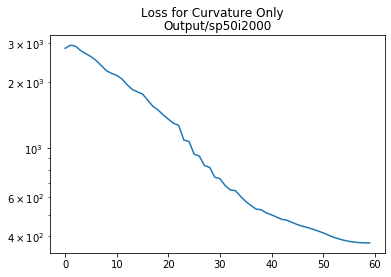

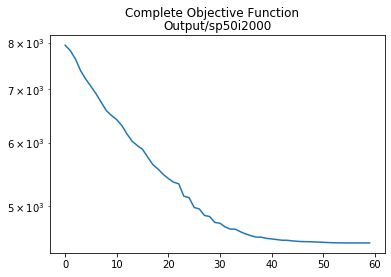

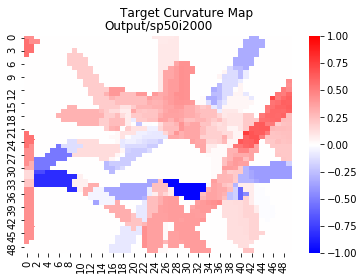

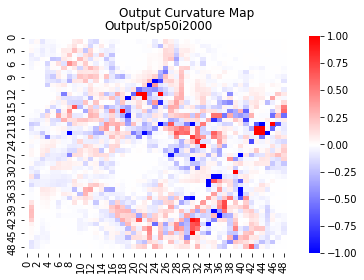

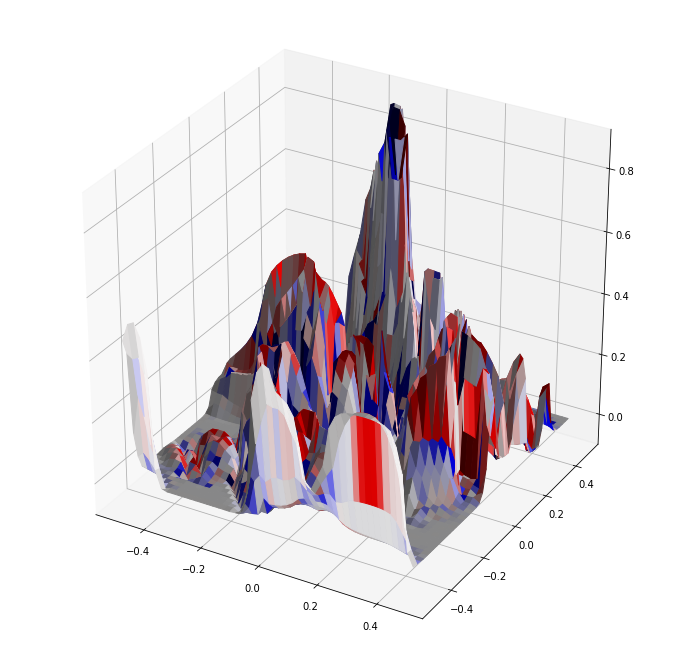

In [39]:
smooth_pen = 50
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 2647.7507460531633
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
finished rate setting: rate: 6.830134553650706e-05 obj fn: 1944.23409756689 complete obj fn: 2513.4334010406387
step: 0 -- lowering rate to 6.20921323059155e-05
step: 1 -- lowering rate to 5.644739300537773e-05
step: 2 -- lowering rate to 5.131581182307066e-05
step: 3 -- lowering rate to 4.665073802097332e-05
step: 4 -- lowering rate to 4.240976183724847e-05
step: 8 -- lowering rate to 3.8554328942953155e-05
step: 36 -- lowering rate to 3.504938994813923e-05
step: 39 -- lowering rate to 3.1863081771035665e-05
step: 42 -- lowering rate to 2.8966437973668783e-05
step: 45 -- lowering rate to 2.633312543060798e-05
step: 48 -- lowering rate to 2.3939204936916344e-05
step: 51 -- lowering rate to 2.176291

step: 216 -- lowering rate to 3.838254789106813e-11
step: 217 -- lowering rate to 3.489322535551648e-11
step: 218 -- lowering rate to 3.172111395956043e-11
step: 219 -- lowering rate to 2.8837376326873116e-11
step: 220 -- lowering rate to 2.621579666079374e-11
step: 221 -- lowering rate to 2.3832542418903398e-11
step: 222 -- lowering rate to 2.1665947653548543e-11
step: 223 -- lowering rate to 1.9696316048680493e-11
step: 224 -- lowering rate to 1.790574186243681e-11
step: 225 -- lowering rate to 1.6277947147669826e-11
step: 226 -- lowering rate to 1.479813377060893e-11
step: 227 -- lowering rate to 1.3452848882371755e-11
step: 228 -- lowering rate to 1.2229862620337958e-11
step: 229 -- lowering rate to 1.1118056927579962e-11
step: 230 -- lowering rate to 1.0107324479618146e-11
step: 231 -- lowering rate to 9.18847679965286e-12
step: 232 -- lowering rate to 8.353160726957144e-12
step: 233 -- lowering rate to 7.593782479051949e-12
step: 234 -- lowering rate to 6.903438617319953e-12
step

step: 373 -- lowering rate to 1.7825961789582685e-17
step: 374 -- raising rate to 1.9608557968540955e-17
step: 375 -- lowering rate to 1.7825961789582685e-17
step: 376 -- raising rate to 1.9608557968540955e-17
step: 377 -- lowering rate to 1.7825961789582685e-17
step: 378 -- raising rate to 1.9608557968540955e-17
step: 379 -- lowering rate to 1.7825961789582685e-17
step: 380 -- raising rate to 1.9608557968540955e-17
step: 381 -- lowering rate to 1.7825961789582685e-17
step: 382 -- raising rate to 1.9608557968540955e-17
step: 383 -- lowering rate to 1.7825961789582685e-17
step: 384 -- raising rate to 1.9608557968540955e-17
step: 385 -- lowering rate to 1.7825961789582685e-17
step: 386 -- raising rate to 1.9608557968540955e-17
step: 387 -- lowering rate to 1.7825961789582685e-17
step: 388 -- raising rate to 1.9608557968540955e-17
step: 389 -- lowering rate to 1.7825961789582685e-17
step: 390 -- raising rate to 1.9608557968540955e-17
step: 391 -- lowering rate to 1.7825961789582685e-17
st

step: 530 -- raising rate to 1.9608557968540955e-17
step: 531 -- lowering rate to 1.7825961789582685e-17
step: 532 -- raising rate to 1.9608557968540955e-17
step: 533 -- lowering rate to 1.7825961789582685e-17
step: 534 -- raising rate to 1.9608557968540955e-17
step: 535 -- lowering rate to 1.7825961789582685e-17
step: 536 -- raising rate to 1.9608557968540955e-17
step: 537 -- lowering rate to 1.7825961789582685e-17
step: 538 -- raising rate to 1.9608557968540955e-17
step: 539 -- lowering rate to 1.7825961789582685e-17
step: 540 -- raising rate to 1.9608557968540955e-17
step: 541 -- lowering rate to 1.7825961789582685e-17
step: 542 -- raising rate to 1.9608557968540955e-17
step: 543 -- lowering rate to 1.7825961789582685e-17
step: 544 -- raising rate to 1.9608557968540955e-17
step: 545 -- lowering rate to 1.7825961789582685e-17
step: 546 -- raising rate to 1.9608557968540955e-17
step: 547 -- lowering rate to 1.7825961789582685e-17
step: 548 -- raising rate to 1.9608557968540955e-17
ste

step: 687 -- lowering rate to 1.7825961789582685e-17
step: 688 -- raising rate to 1.9608557968540955e-17
step: 689 -- lowering rate to 1.7825961789582685e-17
step: 690 -- raising rate to 1.9608557968540955e-17
step: 691 -- lowering rate to 1.7825961789582685e-17
step: 692 -- raising rate to 1.9608557968540955e-17
step: 693 -- lowering rate to 1.7825961789582685e-17
step: 694 -- raising rate to 1.9608557968540955e-17
step: 695 -- lowering rate to 1.7825961789582685e-17
step: 696 -- raising rate to 1.9608557968540955e-17
step: 697 -- lowering rate to 1.7825961789582685e-17
step: 698 -- raising rate to 1.9608557968540955e-17
step: 699 -- lowering rate to 1.7825961789582685e-17
step: 700 -- raising rate to 1.9608557968540955e-17
step: 701 -- lowering rate to 1.7825961789582685e-17
step: 702 -- raising rate to 1.9608557968540955e-17
step: 703 -- lowering rate to 1.7825961789582685e-17
step: 704 -- raising rate to 1.9608557968540955e-17
step: 705 -- lowering rate to 1.7825961789582685e-17
st

step: 844 -- raising rate to 1.9608557968540955e-17
step: 845 -- lowering rate to 1.7825961789582685e-17
step: 846 -- raising rate to 1.9608557968540955e-17
step: 847 -- lowering rate to 1.7825961789582685e-17
step: 848 -- raising rate to 1.9608557968540955e-17
step: 849 -- lowering rate to 1.7825961789582685e-17
step: 850 -- raising rate to 1.9608557968540955e-17
step: 851 -- lowering rate to 1.7825961789582685e-17
step: 852 -- raising rate to 1.9608557968540955e-17
step: 853 -- lowering rate to 1.7825961789582685e-17
step: 854 -- raising rate to 1.9608557968540955e-17
step: 855 -- lowering rate to 1.7825961789582685e-17
step: 856 -- raising rate to 1.9608557968540955e-17
step: 857 -- lowering rate to 1.7825961789582685e-17
step: 858 -- raising rate to 1.9608557968540955e-17
step: 859 -- lowering rate to 1.7825961789582685e-17
step: 860 -- raising rate to 1.9608557968540955e-17
step: 861 -- lowering rate to 1.7825961789582685e-17
step: 862 -- raising rate to 1.9608557968540955e-17
ste

step: 1001 -- lowering rate to 1.7825961789582685e-17
step: 1002 -- raising rate to 1.9608557968540955e-17
step: 1003 -- lowering rate to 1.7825961789582685e-17
step: 1004 -- raising rate to 1.9608557968540955e-17
step: 1005 -- lowering rate to 1.7825961789582685e-17
step: 1006 -- raising rate to 1.9608557968540955e-17
step: 1007 -- lowering rate to 1.7825961789582685e-17
step: 1008 -- raising rate to 1.9608557968540955e-17
step: 1009 -- lowering rate to 1.7825961789582685e-17
step: 1010 -- raising rate to 1.9608557968540955e-17
step: 1011 -- lowering rate to 1.7825961789582685e-17
step: 1012 -- raising rate to 1.9608557968540955e-17
step: 1013 -- lowering rate to 1.7825961789582685e-17
step: 1014 -- raising rate to 1.9608557968540955e-17
step: 1015 -- lowering rate to 1.7825961789582685e-17
step: 1016 -- raising rate to 1.9608557968540955e-17
step: 1017 -- lowering rate to 1.7825961789582685e-17
step: 1018 -- raising rate to 1.9608557968540955e-17
step: 1019 -- lowering rate to 1.7825

step: 1155 -- lowering rate to 1.7825961789582685e-17
step: 1156 -- raising rate to 1.9608557968540955e-17
step: 1157 -- lowering rate to 1.7825961789582685e-17
step: 1158 -- raising rate to 1.9608557968540955e-17
step: 1159 -- lowering rate to 1.7825961789582685e-17
step: 1160 -- raising rate to 1.9608557968540955e-17
step: 1161 -- lowering rate to 1.7825961789582685e-17
step: 1162 -- raising rate to 1.9608557968540955e-17
step: 1163 -- lowering rate to 1.7825961789582685e-17
step: 1164 -- raising rate to 1.9608557968540955e-17
step: 1165 -- lowering rate to 1.7825961789582685e-17
step: 1166 -- raising rate to 1.9608557968540955e-17
step: 1167 -- lowering rate to 1.7825961789582685e-17
step: 1168 -- raising rate to 1.9608557968540955e-17
step: 1169 -- lowering rate to 1.7825961789582685e-17
step: 1170 -- raising rate to 1.9608557968540955e-17
step: 1171 -- lowering rate to 1.7825961789582685e-17
step: 1172 -- raising rate to 1.9608557968540955e-17
step: 1173 -- lowering rate to 1.7825

step: 1309 -- lowering rate to 1.7825961789582685e-17
step: 1310 -- raising rate to 1.9608557968540955e-17
step: 1311 -- lowering rate to 1.7825961789582685e-17
step: 1312 -- raising rate to 1.9608557968540955e-17
step: 1313 -- lowering rate to 1.7825961789582685e-17
step: 1314 -- raising rate to 1.9608557968540955e-17
step: 1315 -- lowering rate to 1.7825961789582685e-17
step: 1316 -- raising rate to 1.9608557968540955e-17
step: 1317 -- lowering rate to 1.7825961789582685e-17
step: 1318 -- raising rate to 1.9608557968540955e-17
step: 1319 -- lowering rate to 1.7825961789582685e-17
step: 1320 -- raising rate to 1.9608557968540955e-17
step: 1321 -- lowering rate to 1.7825961789582685e-17
step: 1322 -- raising rate to 1.9608557968540955e-17
step: 1323 -- lowering rate to 1.7825961789582685e-17
step: 1324 -- raising rate to 1.9608557968540955e-17
step: 1325 -- lowering rate to 1.7825961789582685e-17
step: 1326 -- raising rate to 1.9608557968540955e-17
step: 1327 -- lowering rate to 1.7825

step: 1463 -- lowering rate to 1.7825961789582685e-17
step: 1464 -- raising rate to 1.9608557968540955e-17
step: 1465 -- lowering rate to 1.7825961789582685e-17
step: 1466 -- raising rate to 1.9608557968540955e-17
step: 1467 -- lowering rate to 1.7825961789582685e-17
step: 1468 -- raising rate to 1.9608557968540955e-17
step: 1469 -- lowering rate to 1.7825961789582685e-17
step: 1470 -- raising rate to 1.9608557968540955e-17
step: 1471 -- lowering rate to 1.7825961789582685e-17
step: 1472 -- raising rate to 1.9608557968540955e-17
step: 1473 -- lowering rate to 1.7825961789582685e-17
step: 1474 -- raising rate to 1.9608557968540955e-17
step: 1475 -- lowering rate to 1.7825961789582685e-17
step: 1476 -- raising rate to 1.9608557968540955e-17
step: 1477 -- lowering rate to 1.7825961789582685e-17
step: 1478 -- raising rate to 1.9608557968540955e-17
step: 1479 -- lowering rate to 1.7825961789582685e-17
step: 1480 -- raising rate to 1.9608557968540955e-17
step: 1481 -- lowering rate to 1.7825

step: 1617 -- lowering rate to 1.7825961789582685e-17
step: 1618 -- raising rate to 1.9608557968540955e-17
step: 1619 -- lowering rate to 1.7825961789582685e-17
step: 1620 -- raising rate to 1.9608557968540955e-17
step: 1621 -- lowering rate to 1.7825961789582685e-17
step: 1622 -- raising rate to 1.9608557968540955e-17
step: 1623 -- lowering rate to 1.7825961789582685e-17
step: 1624 -- raising rate to 1.9608557968540955e-17
step: 1625 -- lowering rate to 1.7825961789582685e-17
step: 1626 -- raising rate to 1.9608557968540955e-17
step: 1627 -- lowering rate to 1.7825961789582685e-17
step: 1628 -- raising rate to 1.9608557968540955e-17
step: 1629 -- lowering rate to 1.7825961789582685e-17
step: 1630 -- raising rate to 1.9608557968540955e-17
step: 1631 -- lowering rate to 1.7825961789582685e-17
step: 1632 -- raising rate to 1.9608557968540955e-17
step: 1633 -- lowering rate to 1.7825961789582685e-17
step: 1634 -- raising rate to 1.9608557968540955e-17
step: 1635 -- lowering rate to 1.7825

step: 1771 -- lowering rate to 1.7825961789582685e-17
step: 1772 -- raising rate to 1.9608557968540955e-17
step: 1773 -- lowering rate to 1.7825961789582685e-17
step: 1774 -- raising rate to 1.9608557968540955e-17
step: 1775 -- lowering rate to 1.7825961789582685e-17
step: 1776 -- raising rate to 1.9608557968540955e-17
step: 1777 -- lowering rate to 1.7825961789582685e-17
step: 1778 -- raising rate to 1.9608557968540955e-17
step: 1779 -- lowering rate to 1.7825961789582685e-17
step: 1780 -- raising rate to 1.9608557968540955e-17
step: 1781 -- lowering rate to 1.7825961789582685e-17
step: 1782 -- raising rate to 1.9608557968540955e-17
step: 1783 -- lowering rate to 1.7825961789582685e-17
step: 1784 -- raising rate to 1.9608557968540955e-17
step: 1785 -- lowering rate to 1.7825961789582685e-17
step: 1786 -- raising rate to 1.9608557968540955e-17
step: 1787 -- lowering rate to 1.7825961789582685e-17
step: 1788 -- raising rate to 1.9608557968540955e-17
step: 1789 -- lowering rate to 1.7825

step: 1925 -- lowering rate to 1.7825961789582685e-17
step: 1926 -- raising rate to 1.9608557968540955e-17
step: 1927 -- lowering rate to 1.7825961789582685e-17
step: 1928 -- raising rate to 1.9608557968540955e-17
step: 1929 -- lowering rate to 1.7825961789582685e-17
step: 1930 -- raising rate to 1.9608557968540955e-17
step: 1931 -- lowering rate to 1.7825961789582685e-17
step: 1932 -- raising rate to 1.9608557968540955e-17
step: 1933 -- lowering rate to 1.7825961789582685e-17
step: 1934 -- raising rate to 1.9608557968540955e-17
step: 1935 -- lowering rate to 1.7825961789582685e-17
step: 1936 -- raising rate to 1.9608557968540955e-17
step: 1937 -- lowering rate to 1.7825961789582685e-17
step: 1938 -- raising rate to 1.9608557968540955e-17
step: 1939 -- lowering rate to 1.7825961789582685e-17
step: 1940 -- raising rate to 1.9608557968540955e-17
step: 1941 -- lowering rate to 1.7825961789582685e-17
step: 1942 -- raising rate to 1.9608557968540955e-17
step: 1943 -- lowering rate to 1.7825

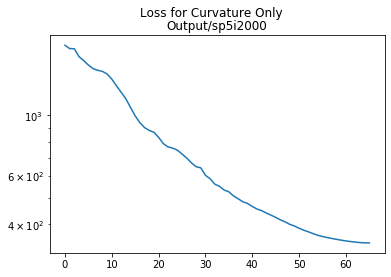

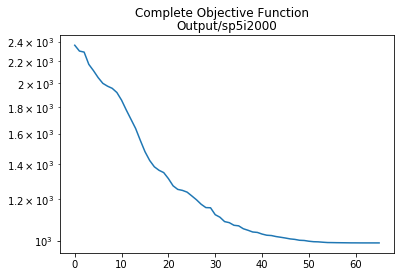

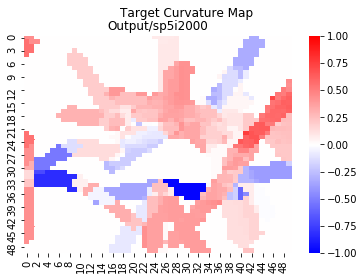

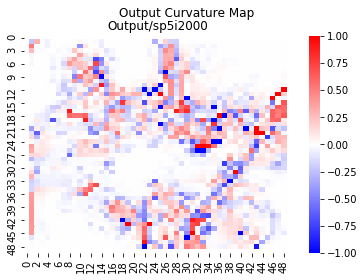

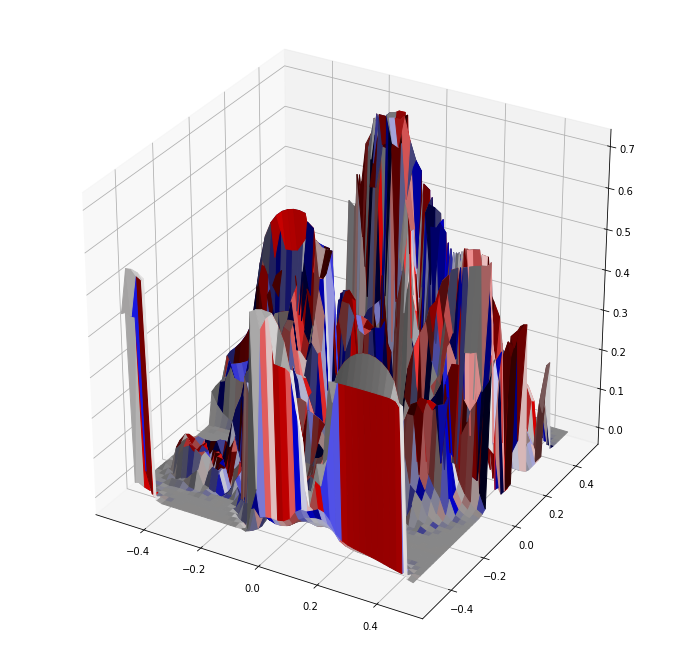

In [40]:
smooth_pen = 5
niter = 2000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 7993.551846568635
setup: -- lowering rate to 9.09090909090909e-05
finished rate setting: rate: 9.09090909090909e-05 obj fn: 2588.2091062331274 complete obj fn: 7974.182382131195
step: 0 -- lowering rate to 8.264462809917355e-05
step: 1 -- lowering rate to 7.513148009015777e-05
step: 2 -- lowering rate to 6.830134553650706e-05
step: 26 -- lowering rate to 6.20921323059155e-05
step: 29 -- lowering rate to 5.644739300537773e-05
step: 32 -- lowering rate to 5.131581182307066e-05
step: 35 -- lowering rate to 4.665073802097332e-05
step: 38 -- lowering rate to 4.240976183724847e-05
step: 42 -- lowering rate to 3.8554328942953155e-05
step: 44 -- lowering rate to 3.504938994813923e-05
step: 46 -- lowering rate to 3.1863081771035665e-05
step: 48 -- lowering rate to 2.8966437973668783e-05
step: 51 -- lowering rate to 2.633312543060798e-05
step: 54 -- lowering rate to 2.3939204936916344e-05
step: 56 -- lowering rate to 

step: 213 -- lowering rate to 3.838254789106813e-11
step: 214 -- lowering rate to 3.489322535551648e-11
step: 215 -- lowering rate to 3.172111395956043e-11
step: 216 -- lowering rate to 2.8837376326873116e-11
step: 217 -- lowering rate to 2.621579666079374e-11
step: 218 -- lowering rate to 2.3832542418903398e-11
step: 219 -- lowering rate to 2.1665947653548543e-11
step: 220 -- lowering rate to 1.9696316048680493e-11
step: 221 -- lowering rate to 1.790574186243681e-11
step: 222 -- lowering rate to 1.6277947147669826e-11
step: 223 -- lowering rate to 1.479813377060893e-11
step: 224 -- lowering rate to 1.3452848882371755e-11
step: 225 -- lowering rate to 1.2229862620337958e-11
step: 226 -- lowering rate to 1.1118056927579962e-11
step: 227 -- lowering rate to 1.0107324479618146e-11
step: 228 -- lowering rate to 9.18847679965286e-12
step: 229 -- lowering rate to 8.353160726957144e-12
step: 230 -- lowering rate to 7.593782479051949e-12
step: 231 -- lowering rate to 6.903438617319953e-12
step

step: 370 -- lowering rate to 3.763733774964352e-16
step: 371 -- raising rate to 4.1401071524607877e-16
step: 372 -- lowering rate to 3.763733774964352e-16
step: 373 -- raising rate to 4.1401071524607877e-16
step: 374 -- lowering rate to 3.763733774964352e-16
step: 375 -- raising rate to 4.1401071524607877e-16
step: 376 -- lowering rate to 3.763733774964352e-16
step: 377 -- raising rate to 4.1401071524607877e-16
step: 378 -- lowering rate to 3.763733774964352e-16
step: 379 -- raising rate to 4.1401071524607877e-16
step: 380 -- lowering rate to 3.763733774964352e-16
step: 381 -- raising rate to 4.1401071524607877e-16
step: 382 -- lowering rate to 3.763733774964352e-16
step: 383 -- raising rate to 4.1401071524607877e-16
step: 384 -- lowering rate to 3.763733774964352e-16
step: 385 -- raising rate to 4.1401071524607877e-16
step: 386 -- lowering rate to 3.763733774964352e-16
step: 387 -- raising rate to 4.1401071524607877e-16
step: 388 -- lowering rate to 3.763733774964352e-16
step: 389 --

step: 528 -- lowering rate to 3.763733774964352e-16
step: 529 -- raising rate to 4.1401071524607877e-16
step: 530 -- lowering rate to 3.763733774964352e-16
step: 531 -- raising rate to 4.1401071524607877e-16
step: 532 -- lowering rate to 3.763733774964352e-16
step: 533 -- raising rate to 4.1401071524607877e-16
step: 534 -- lowering rate to 3.763733774964352e-16
step: 535 -- raising rate to 4.1401071524607877e-16
step: 536 -- lowering rate to 3.763733774964352e-16
step: 537 -- raising rate to 4.1401071524607877e-16
step: 538 -- lowering rate to 3.763733774964352e-16
step: 539 -- raising rate to 4.1401071524607877e-16
step: 540 -- lowering rate to 3.763733774964352e-16
step: 541 -- raising rate to 4.1401071524607877e-16
step: 542 -- lowering rate to 3.763733774964352e-16
step: 543 -- raising rate to 4.1401071524607877e-16
step: 544 -- lowering rate to 3.763733774964352e-16
step: 545 -- raising rate to 4.1401071524607877e-16
step: 546 -- lowering rate to 3.763733774964352e-16
step: 547 --

step: 686 -- lowering rate to 3.763733774964352e-16
step: 687 -- raising rate to 4.1401071524607877e-16
step: 688 -- lowering rate to 3.763733774964352e-16
step: 689 -- raising rate to 4.1401071524607877e-16
step: 690 -- lowering rate to 3.763733774964352e-16
step: 691 -- raising rate to 4.1401071524607877e-16
step: 692 -- lowering rate to 3.763733774964352e-16
step: 693 -- raising rate to 4.1401071524607877e-16
step: 694 -- lowering rate to 3.763733774964352e-16
step: 695 -- raising rate to 4.1401071524607877e-16
step: 696 -- lowering rate to 3.763733774964352e-16
step: 697 -- raising rate to 4.1401071524607877e-16
step: 698 -- lowering rate to 3.763733774964352e-16
step: 699 -- raising rate to 4.1401071524607877e-16
step: 700 -- lowering rate to 3.763733774964352e-16
step: 701 -- raising rate to 4.1401071524607877e-16
step: 702 -- lowering rate to 3.763733774964352e-16
step: 703 -- raising rate to 4.1401071524607877e-16
step: 704 -- lowering rate to 3.763733774964352e-16
step: 705 --

step: 844 -- lowering rate to 3.763733774964352e-16
step: 845 -- raising rate to 4.1401071524607877e-16
step: 846 -- lowering rate to 3.763733774964352e-16
step: 847 -- raising rate to 4.1401071524607877e-16
step: 848 -- lowering rate to 3.763733774964352e-16
step: 849 -- raising rate to 4.1401071524607877e-16
step: 850 -- lowering rate to 3.763733774964352e-16
step: 851 -- raising rate to 4.1401071524607877e-16
step: 852 -- lowering rate to 3.763733774964352e-16
step: 853 -- raising rate to 4.1401071524607877e-16
step: 854 -- lowering rate to 3.763733774964352e-16
step: 855 -- raising rate to 4.1401071524607877e-16
step: 856 -- lowering rate to 3.763733774964352e-16
step: 857 -- raising rate to 4.1401071524607877e-16
step: 858 -- lowering rate to 3.763733774964352e-16
step: 859 -- raising rate to 4.1401071524607877e-16
step: 860 -- lowering rate to 3.763733774964352e-16
step: 861 -- raising rate to 4.1401071524607877e-16
step: 862 -- lowering rate to 3.763733774964352e-16
step: 863 --

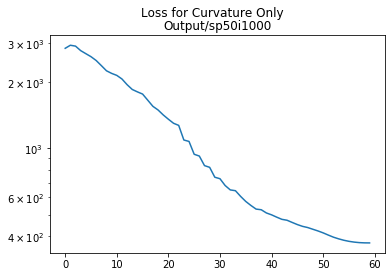

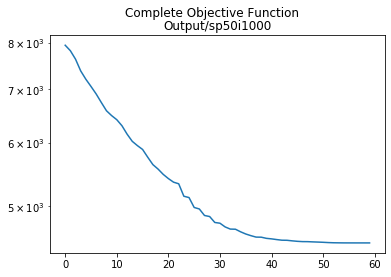

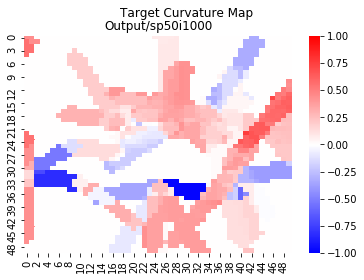

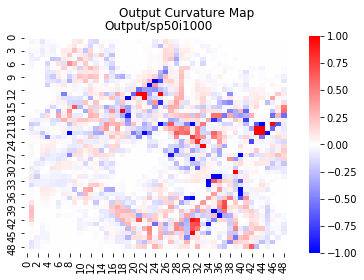

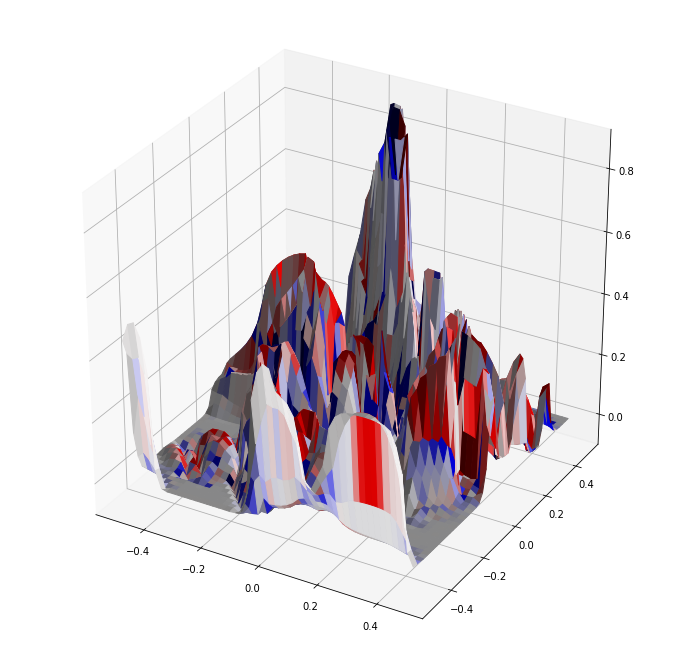

In [41]:
smooth_pen = 50
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 2647.7507460531633
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
finished rate setting: rate: 6.830134553650706e-05 obj fn: 1944.23409756689 complete obj fn: 2513.4334010406387
step: 0 -- lowering rate to 6.20921323059155e-05
step: 1 -- lowering rate to 5.644739300537773e-05
step: 2 -- lowering rate to 5.131581182307066e-05
step: 3 -- lowering rate to 4.665073802097332e-05
step: 4 -- lowering rate to 4.240976183724847e-05
step: 8 -- lowering rate to 3.8554328942953155e-05
step: 36 -- lowering rate to 3.504938994813923e-05
step: 39 -- lowering rate to 3.1863081771035665e-05
step: 42 -- lowering rate to 2.8966437973668783e-05
step: 45 -- lowering rate to 2.633312543060798e-05
step: 48 -- lowering rate to 2.3939204936916344e-05
step: 51 -- lowering rate to 2.176291

step: 216 -- lowering rate to 3.838254789106813e-11
step: 217 -- lowering rate to 3.489322535551648e-11
step: 218 -- lowering rate to 3.172111395956043e-11
step: 219 -- lowering rate to 2.8837376326873116e-11
step: 220 -- lowering rate to 2.621579666079374e-11
step: 221 -- lowering rate to 2.3832542418903398e-11
step: 222 -- lowering rate to 2.1665947653548543e-11
step: 223 -- lowering rate to 1.9696316048680493e-11
step: 224 -- lowering rate to 1.790574186243681e-11
step: 225 -- lowering rate to 1.6277947147669826e-11
step: 226 -- lowering rate to 1.479813377060893e-11
step: 227 -- lowering rate to 1.3452848882371755e-11
step: 228 -- lowering rate to 1.2229862620337958e-11
step: 229 -- lowering rate to 1.1118056927579962e-11
step: 230 -- lowering rate to 1.0107324479618146e-11
step: 231 -- lowering rate to 9.18847679965286e-12
step: 232 -- lowering rate to 8.353160726957144e-12
step: 233 -- lowering rate to 7.593782479051949e-12
step: 234 -- lowering rate to 6.903438617319953e-12
step

step: 373 -- lowering rate to 1.7825961789582685e-17
step: 374 -- raising rate to 1.9608557968540955e-17
step: 375 -- lowering rate to 1.7825961789582685e-17
step: 376 -- raising rate to 1.9608557968540955e-17
step: 377 -- lowering rate to 1.7825961789582685e-17
step: 378 -- raising rate to 1.9608557968540955e-17
step: 379 -- lowering rate to 1.7825961789582685e-17
step: 380 -- raising rate to 1.9608557968540955e-17
step: 381 -- lowering rate to 1.7825961789582685e-17
step: 382 -- raising rate to 1.9608557968540955e-17
step: 383 -- lowering rate to 1.7825961789582685e-17
step: 384 -- raising rate to 1.9608557968540955e-17
step: 385 -- lowering rate to 1.7825961789582685e-17
step: 386 -- raising rate to 1.9608557968540955e-17
step: 387 -- lowering rate to 1.7825961789582685e-17
step: 388 -- raising rate to 1.9608557968540955e-17
step: 389 -- lowering rate to 1.7825961789582685e-17
step: 390 -- raising rate to 1.9608557968540955e-17
step: 391 -- lowering rate to 1.7825961789582685e-17
st

step: 530 -- raising rate to 1.9608557968540955e-17
step: 531 -- lowering rate to 1.7825961789582685e-17
step: 532 -- raising rate to 1.9608557968540955e-17
step: 533 -- lowering rate to 1.7825961789582685e-17
step: 534 -- raising rate to 1.9608557968540955e-17
step: 535 -- lowering rate to 1.7825961789582685e-17
step: 536 -- raising rate to 1.9608557968540955e-17
step: 537 -- lowering rate to 1.7825961789582685e-17
step: 538 -- raising rate to 1.9608557968540955e-17
step: 539 -- lowering rate to 1.7825961789582685e-17
step: 540 -- raising rate to 1.9608557968540955e-17
step: 541 -- lowering rate to 1.7825961789582685e-17
step: 542 -- raising rate to 1.9608557968540955e-17
step: 543 -- lowering rate to 1.7825961789582685e-17
step: 544 -- raising rate to 1.9608557968540955e-17
step: 545 -- lowering rate to 1.7825961789582685e-17
step: 546 -- raising rate to 1.9608557968540955e-17
step: 547 -- lowering rate to 1.7825961789582685e-17
step: 548 -- raising rate to 1.9608557968540955e-17
ste

step: 687 -- lowering rate to 1.7825961789582685e-17
step: 688 -- raising rate to 1.9608557968540955e-17
step: 689 -- lowering rate to 1.7825961789582685e-17
step: 690 -- raising rate to 1.9608557968540955e-17
step: 691 -- lowering rate to 1.7825961789582685e-17
step: 692 -- raising rate to 1.9608557968540955e-17
step: 693 -- lowering rate to 1.7825961789582685e-17
step: 694 -- raising rate to 1.9608557968540955e-17
step: 695 -- lowering rate to 1.7825961789582685e-17
step: 696 -- raising rate to 1.9608557968540955e-17
step: 697 -- lowering rate to 1.7825961789582685e-17
step: 698 -- raising rate to 1.9608557968540955e-17
step: 699 -- lowering rate to 1.7825961789582685e-17
step: 700 -- raising rate to 1.9608557968540955e-17
step: 701 -- lowering rate to 1.7825961789582685e-17
step: 702 -- raising rate to 1.9608557968540955e-17
step: 703 -- lowering rate to 1.7825961789582685e-17
step: 704 -- raising rate to 1.9608557968540955e-17
step: 705 -- lowering rate to 1.7825961789582685e-17
st

step: 844 -- raising rate to 1.9608557968540955e-17
step: 845 -- lowering rate to 1.7825961789582685e-17
step: 846 -- raising rate to 1.9608557968540955e-17
step: 847 -- lowering rate to 1.7825961789582685e-17
step: 848 -- raising rate to 1.9608557968540955e-17
step: 849 -- lowering rate to 1.7825961789582685e-17
step: 850 -- raising rate to 1.9608557968540955e-17
step: 851 -- lowering rate to 1.7825961789582685e-17
step: 852 -- raising rate to 1.9608557968540955e-17
step: 853 -- lowering rate to 1.7825961789582685e-17
step: 854 -- raising rate to 1.9608557968540955e-17
step: 855 -- lowering rate to 1.7825961789582685e-17
step: 856 -- raising rate to 1.9608557968540955e-17
step: 857 -- lowering rate to 1.7825961789582685e-17
step: 858 -- raising rate to 1.9608557968540955e-17
step: 859 -- lowering rate to 1.7825961789582685e-17
step: 860 -- raising rate to 1.9608557968540955e-17
step: 861 -- lowering rate to 1.7825961789582685e-17
step: 862 -- raising rate to 1.9608557968540955e-17
ste

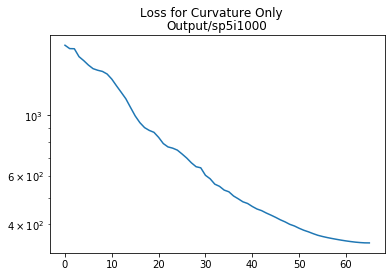

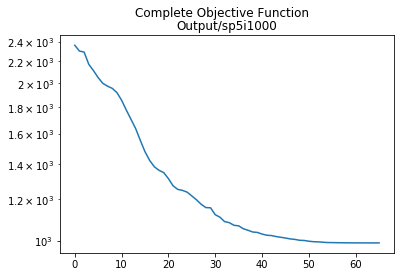

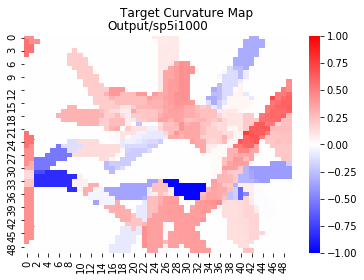

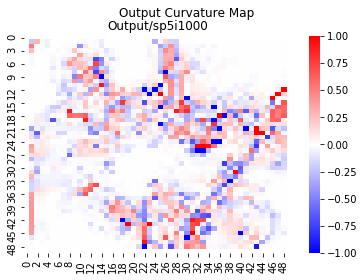

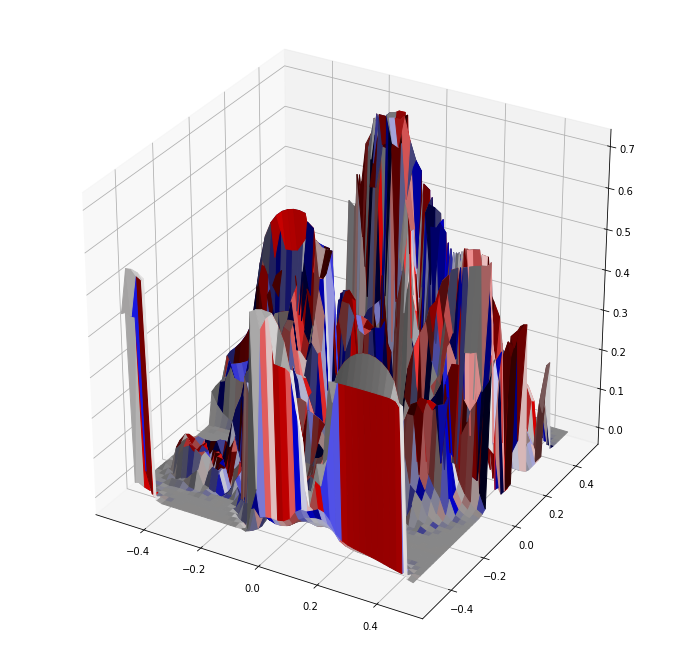

In [42]:
smooth_pen = 5
niter = 1000
momentum = 0.9
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 13933.33084714138
finished rate setting: rate: 0.0001 obj fn: 2772.812652086687 complete obj fn: 12855.628823857507
step: 0 -- lowering rate to 9.09090909090909e-05
step: 1 -- lowering rate to 8.264462809917355e-05
step: 2 -- lowering rate to 7.513148009015777e-05
step: 3 -- lowering rate to 6.830134553650706e-05
step: 4 -- lowering rate to 6.20921323059155e-05
step: 5 -- lowering rate to 5.644739300537773e-05
step: 6 -- lowering rate to 5.131581182307066e-05
step: 7 -- lowering rate to 4.665073802097332e-05
step: 8 -- lowering rate to 4.240976183724847e-05
step: 9 -- lowering rate to 3.8554328942953155e-05
step: 10 -- lowering rate to 3.504938994813923e-05
step: 11 -- lowering rate to 3.1863081771035665e-05
step: 12 -- lowering rate to 2.8966437973668783e-05
step: 13 -- lowering rate to 2.633312543060798e-05
step: 14 -- lowering rate to 2.3939204936916344e-05
step: 15 -- lowering rate to 2.1762913579014857e

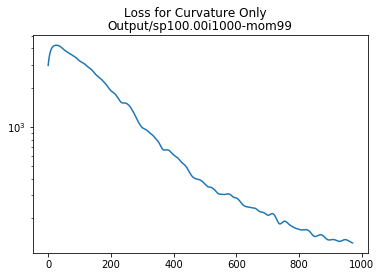

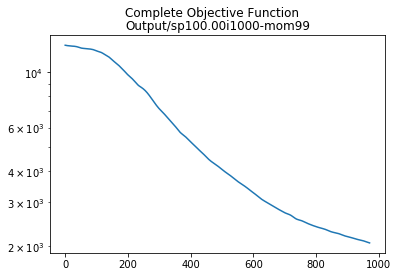

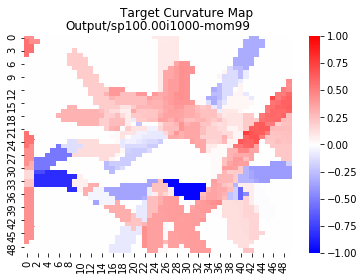

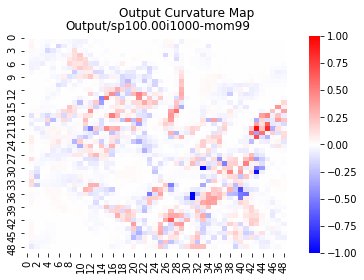

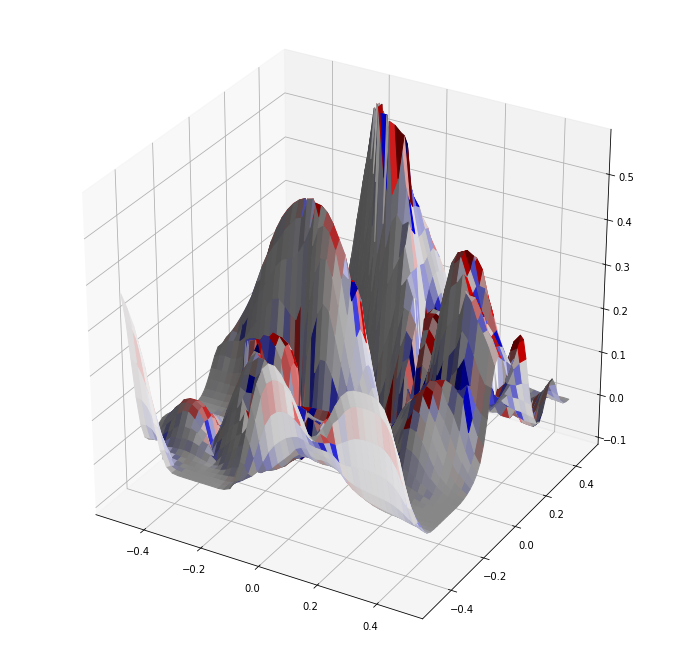

In [43]:
smooth_pen = 100
niter = 1000
momentum = 0.99
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:.2f}i{:d}-mom99'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

In [44]:
# plotting options:
# plot_surface: https://matplotlib.org/gallery/mplot3d/custom_shaded_3d_surface.html#sphx-glr-gallery-mplot3d-custom-shaded-3d-surface-py
# plot_trisurf
# Poly3DCollection directly

In [45]:
triangulation = mp.tri.Triangulation(xf, yf, triangles=triangles)

NameError: name 'pcv' is not defined

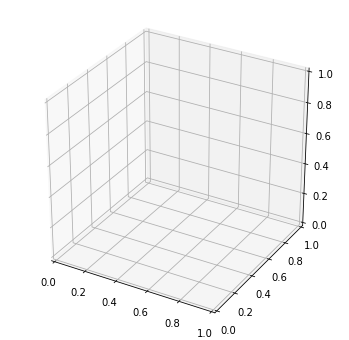

In [46]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

#ax.axes.set_xlim([xmin, xmax])
#ax.axes.set_ylim([ymin, ymax])
#ax.axes.set_zlim([zmin, zmax])
#ax.axes.set_xlabel('$x_1$',size=15)
#ax.axes.set_ylabel('$x_2$',size=15)
#ax.axes.set_zlabel('$x_3$',size=15)

#triang = mp.tri.Triangulation(X, Y, triangles=triangles)

#zs = np.array([fun(x, y) for x, y in zip(X, Y)])
facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])
ax.plot_trisurf(triangulation,
                            zf,
                            # color='red',
                            # alpha=alpha,
                            linewidth=0, facecolors = facecolors)
plt.show()